# Supervised Clustering with SHAP Values

----------------------------

## Importing libraries, preparing data and creating functions

In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib import style
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



shap.initjs()

In [78]:
#time function to track running time
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now()- start_time).total_seconds(), 3600)
        tmin, tsec= divmod(temp_sec, 60)
        print("\n Time taken: %i hours %i minutes and %i seconds." % (thour, tmin, round(tsec,2)))
        
#function to calculate features to remove based on correlation
def correlation(dataset, threshold):
    col_corr=set()
    corr_matrix=dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname=corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

#Calculate accuracy and fale positive rate of binary classification
def accuracy0MalwareClass(dataset):
    count= 0
    for i in range(len(dataset)):
        if (dataset["Cluster"][i]== 0 and dataset["Class"][i]== "Malware") or (dataset["Cluster"][i]== 1 and dataset["Class"][i]== "Benign"):
            count += 1
        
    return print("Accuracy:", count/len(dataset)*100, "% \n False Positive rate:", len(dataset[dataset.Cluster==1][dataset.Class== "Malware"])/(len(dataset[dataset.Cluster==1][dataset.Class== "Malware"])+len(dataset[dataset.Cluster==0][dataset.Class=="Malware"])) * 100, "%") 

def accuracy0BenignClass(dataset):
    count= 0
    for i in range(len(dataset)):
        if (dataset["Cluster"][i]== 1 and dataset["Class"][i]== "Malware") or (dataset["Cluster"][i]== 0 and dataset["Class"][i]== "Benign"):
            count += 1
        
    return print("Accuracy:", count/len(dataset)*100, "% \n False Positive rate:", len(dataset[dataset.Cluster==0][dataset.Class== "Malware"])/(len(dataset[dataset.Cluster==0][dataset.Class== "Malware"])+len(dataset[dataset.Cluster==1][dataset.Class=="Malware"])) * 100, "%") 


In [3]:
#Importing the data 
dataset= pd.read_csv("C:/Users/rodri/OneDrive/Desktop/tese/Data/Obfuscated-MalMem2022.csv")

#Separating the Category column into category and family
dataset[["Category", "Family1", "idk"]]=dataset["Category"].str.split("-", n=2, expand= True)
dataset.drop("idk",axis=1, inplace= True)


#Arranging the family column
classes=[]
for i in range(len(dataset)):
    if dataset["Class"][i]== "Benign":
        classes.append("Benign")
    else:
        classes.append(dataset["Family1"][i])
dataset["Family"]= classes

dataset.drop("Family1", axis=1,inplace= True)

#Dropping meaningless features
dataset.drop(["pslist.nprocs64bit","handles.nport","svcscan.interactive_process_services"], axis= 1, inplace= True)


In [4]:
pd.set_option('display.max_columns', None)
dataset.describe()

pslist.nproc  pslist.nppid  pslist.avg_threads  pslist.avg_handlers  \
count  58596.000000  58596.000000        58596.000000         58596.000000   
mean      41.394771     14.713837           11.341655           247.509819   
std        5.777249      2.656748            1.588231           111.857790   
min       21.000000      8.000000            1.650000            34.962500   
25%       40.000000     12.000000            9.972973           208.725000   
50%       41.000000     15.000000           11.000000           243.963710   
75%       43.000000     16.000000           12.861955           289.974322   
max      240.000000     72.000000           16.818182         24845.951220   

       dlllist.ndlls  dlllist.avg_dlls_per_proc  handles.nhandles  \
count   58596.000000               58596.000000      5.859600e+04   
mean     1810.805447                  43.707806      1.025858e+04   
std       329.782639                   5.742023      4.866864e+03   
min       670.000000                   7.333333      3.514000e+03   
25%      1556.000000                  38.833333      8.393000e+03   
50%      1735.000000                  42.781524      9.287500e+03   
75%      2087.000000                  49.605280      1.219300e+04   
max      3443.000000                  53.170732      1.047310e+06   

       handles.avg_handles_per_proc  handles.nfile  handles.nevent  \
count                  58596.000000   58596.000000    58596.000000   
mean                     249.560958     899.119513     3572.409960   
std                      145.999866    3432.351200      805.460522   
min                       71.139241     266.000000      966.000000   
25%                      209.648228     646.000000     2923.000000   
50%                      247.208951     839.000000     3151.000000   
75%                      291.355050    1080.000000     4321.000000   
max                    33784.193550  807008.000000     7892.000000   

       handles.ndesktop  handles.nkey  handles.nthread  handles.ndirectory  \
count      58596.000000  58596.000000     58596.000000        58596.000000   
mean          44.529166    774.280668       928.510086          102.398338   
std            5.161254    150.407075       237.817566            9.782695   
min           22.000000    284.000000       388.000000           57.000000   
25%           43.000000    675.000000       708.000000           99.000000   
50%           45.000000    753.000000       848.000000          103.000000   
75%           46.000000    859.000000      1169.000000          107.000000   
max          159.000000   2668.000000      5637.000000          498.000000   

       handles.nsemaphore  handles.ntimer  handles.nsection  handles.nmutant  \
count        58596.000000    58596.000000      58596.000000     58596.000000   
mean           683.339324      130.327855        290.127466       312.588829   
std             94.531078       14.965266        144.278832        73.173189   
min            296.000000       69.000000         50.000000       118.000000   
25%            614.000000      120.000000        177.000000       258.000000   
50%            684.000000      131.000000        224.000000       289.000000   
75%            750.000000      142.000000        415.000000       366.000000   
max           4268.000000      382.000000      14687.000000       583.000000   

       ldrmodules.not_in_load  ldrmodules.not_in_init  ldrmodules.not_in_mem  \
count            58596.000000            58596.000000           58596.000000   
mean                60.830347               99.946413              60.832599   
std                 18.761422               21.438482              18.759947   
min                  6.000000               16.000000               6.000000   
25%                 46.000000               85.000000              46.000000   
50%                 57.000000               97.000000              57.000000   
75%                 74.000000              115.000000              

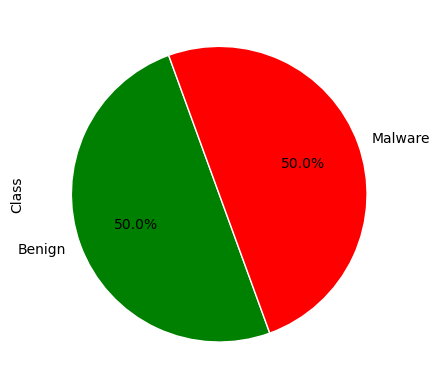

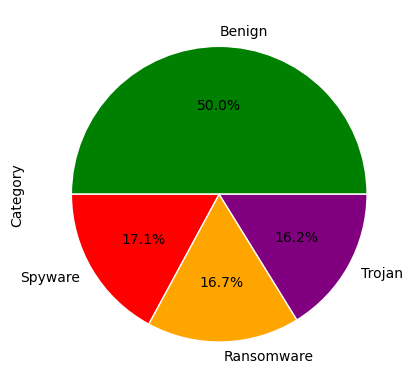

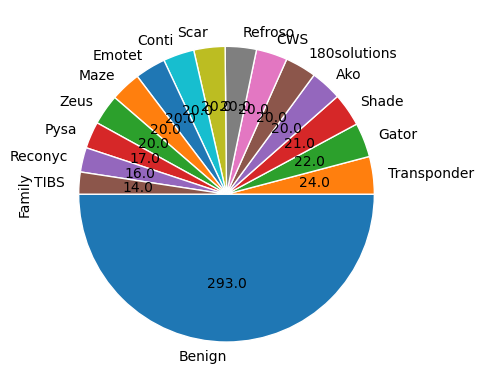

In [5]:
#Producing pie charts to vizualise the data

sizes=[]
for i in range(len(dataset.Family.value_counts())):
     sizes.append(dataset.Family.value_counts()[i])
        
sizes=np.array(sizes)
        
def absolute_value(val):
    a  = np.round(val/10000.*sizes.sum(), decimals=0)
    return a

dataset.Class.value_counts().plot.pie(wedgeprops={'edgecolor': 'white'}, autopct='%1.1f%%',startangle=110, colors=["Green", "Red"])
plt.show()

dataset.Category.value_counts().plot.pie(wedgeprops={'edgecolor': 'white'}, autopct='%1.1f%%', colors=["Green", "Red", "Orange", "Purple"])
plt.show()

dataset.Family.value_counts().plot.pie(wedgeprops={'edgecolor': 'white'}, autopct=absolute_value,  startangle=180)
plt.show()

In [15]:
print(dataset.Class.value_counts(), "\n")
print("Size of the dataset:", dataset.shape[0])
print("Number of malware families:",len(dataset.Family.value_counts())-1)

Benign     29298
Malware    29298
Name: Class, dtype: int64 

Size of the dataset: 58596
Number of malware families: 15


In [17]:
dataset

Category  pslist.nproc  pslist.nppid  pslist.avg_threads  \
0          Benign            45            17           10.555556   
1          Benign            47            19           11.531915   
2          Benign            40            14           14.725000   
3          Benign            32            13           13.500000   
4          Benign            42            16           11.452381   
...           ...           ...           ...                 ...   
58591  Ransomware            37            15           10.108108   
58592  Ransomware            37            14            9.945946   
58593  Ransomware            38            15            9.842105   
58594  Ransomware            37            15           10.243243   
58595  Ransomware            38            15            9.868421   

       pslist.avg_handlers  dlllist.ndlls  dlllist.avg_dlls_per_proc  \
0               202.844444           1694                  38.500000   
1               242.234043           2074                  44.127660   
2               288.225000           1932                  48.300000   
3               264.281250           1445                  45.156250   
4               281.333333           2067                  49.214286   
...                    ...            ...                        ...   
58591           215.486487           1453                  39.270270   
58592           190.216216           1347                  36.405405   
58593           210.026316           1448                  38.105263   
58594           215.513513           1452                  39.243243   
58595           213.026316           1487                  39.131579   

       handles.nhandles  handles.avg_handles_per_proc  handles.nfile  \
0                  9129                    212.302326            670   
1                 11385                    242.234043            840   
2                 11529                    288.225000           1050   
3                  8457                    264.281250            630   
4                 11816                    281.333333            908   
...                 ...                           ...            ...   
58591              7973                    215.486487            630   
58592              7038                    190.216216            603   
58593              7982                    215.729730            624   
58594              7974                    215.513513            632   
58595              8095                    213.026316            637   

       handles.nevent  handles.ndesktop  handles.nkey  handles.nthread  \
0                3161                46           716              887   
1                3761                51          1011             1030   
2                3996                45           784             1241   
3                2961                36           654              792   
4                3834                45          1252              942   
...               ...               ...           ...              ...   
58591            2819                40           668              664   
58592            2394                39           555              624   
58593            2816                40           673              661   
58594            2819                40           668              667   
58595            2843                41           683              669   

       handles.ndirectory  handles.nsemaphore  handles.ntimer  \
0                     104                 671             125   
1                     117                 766             148   
2                     100                 645             138   
3                      83                 567             127   
4                     103                 825             135   
...                   ...                 ...             ...   
58591                  92                 596             113   
58592                  91                

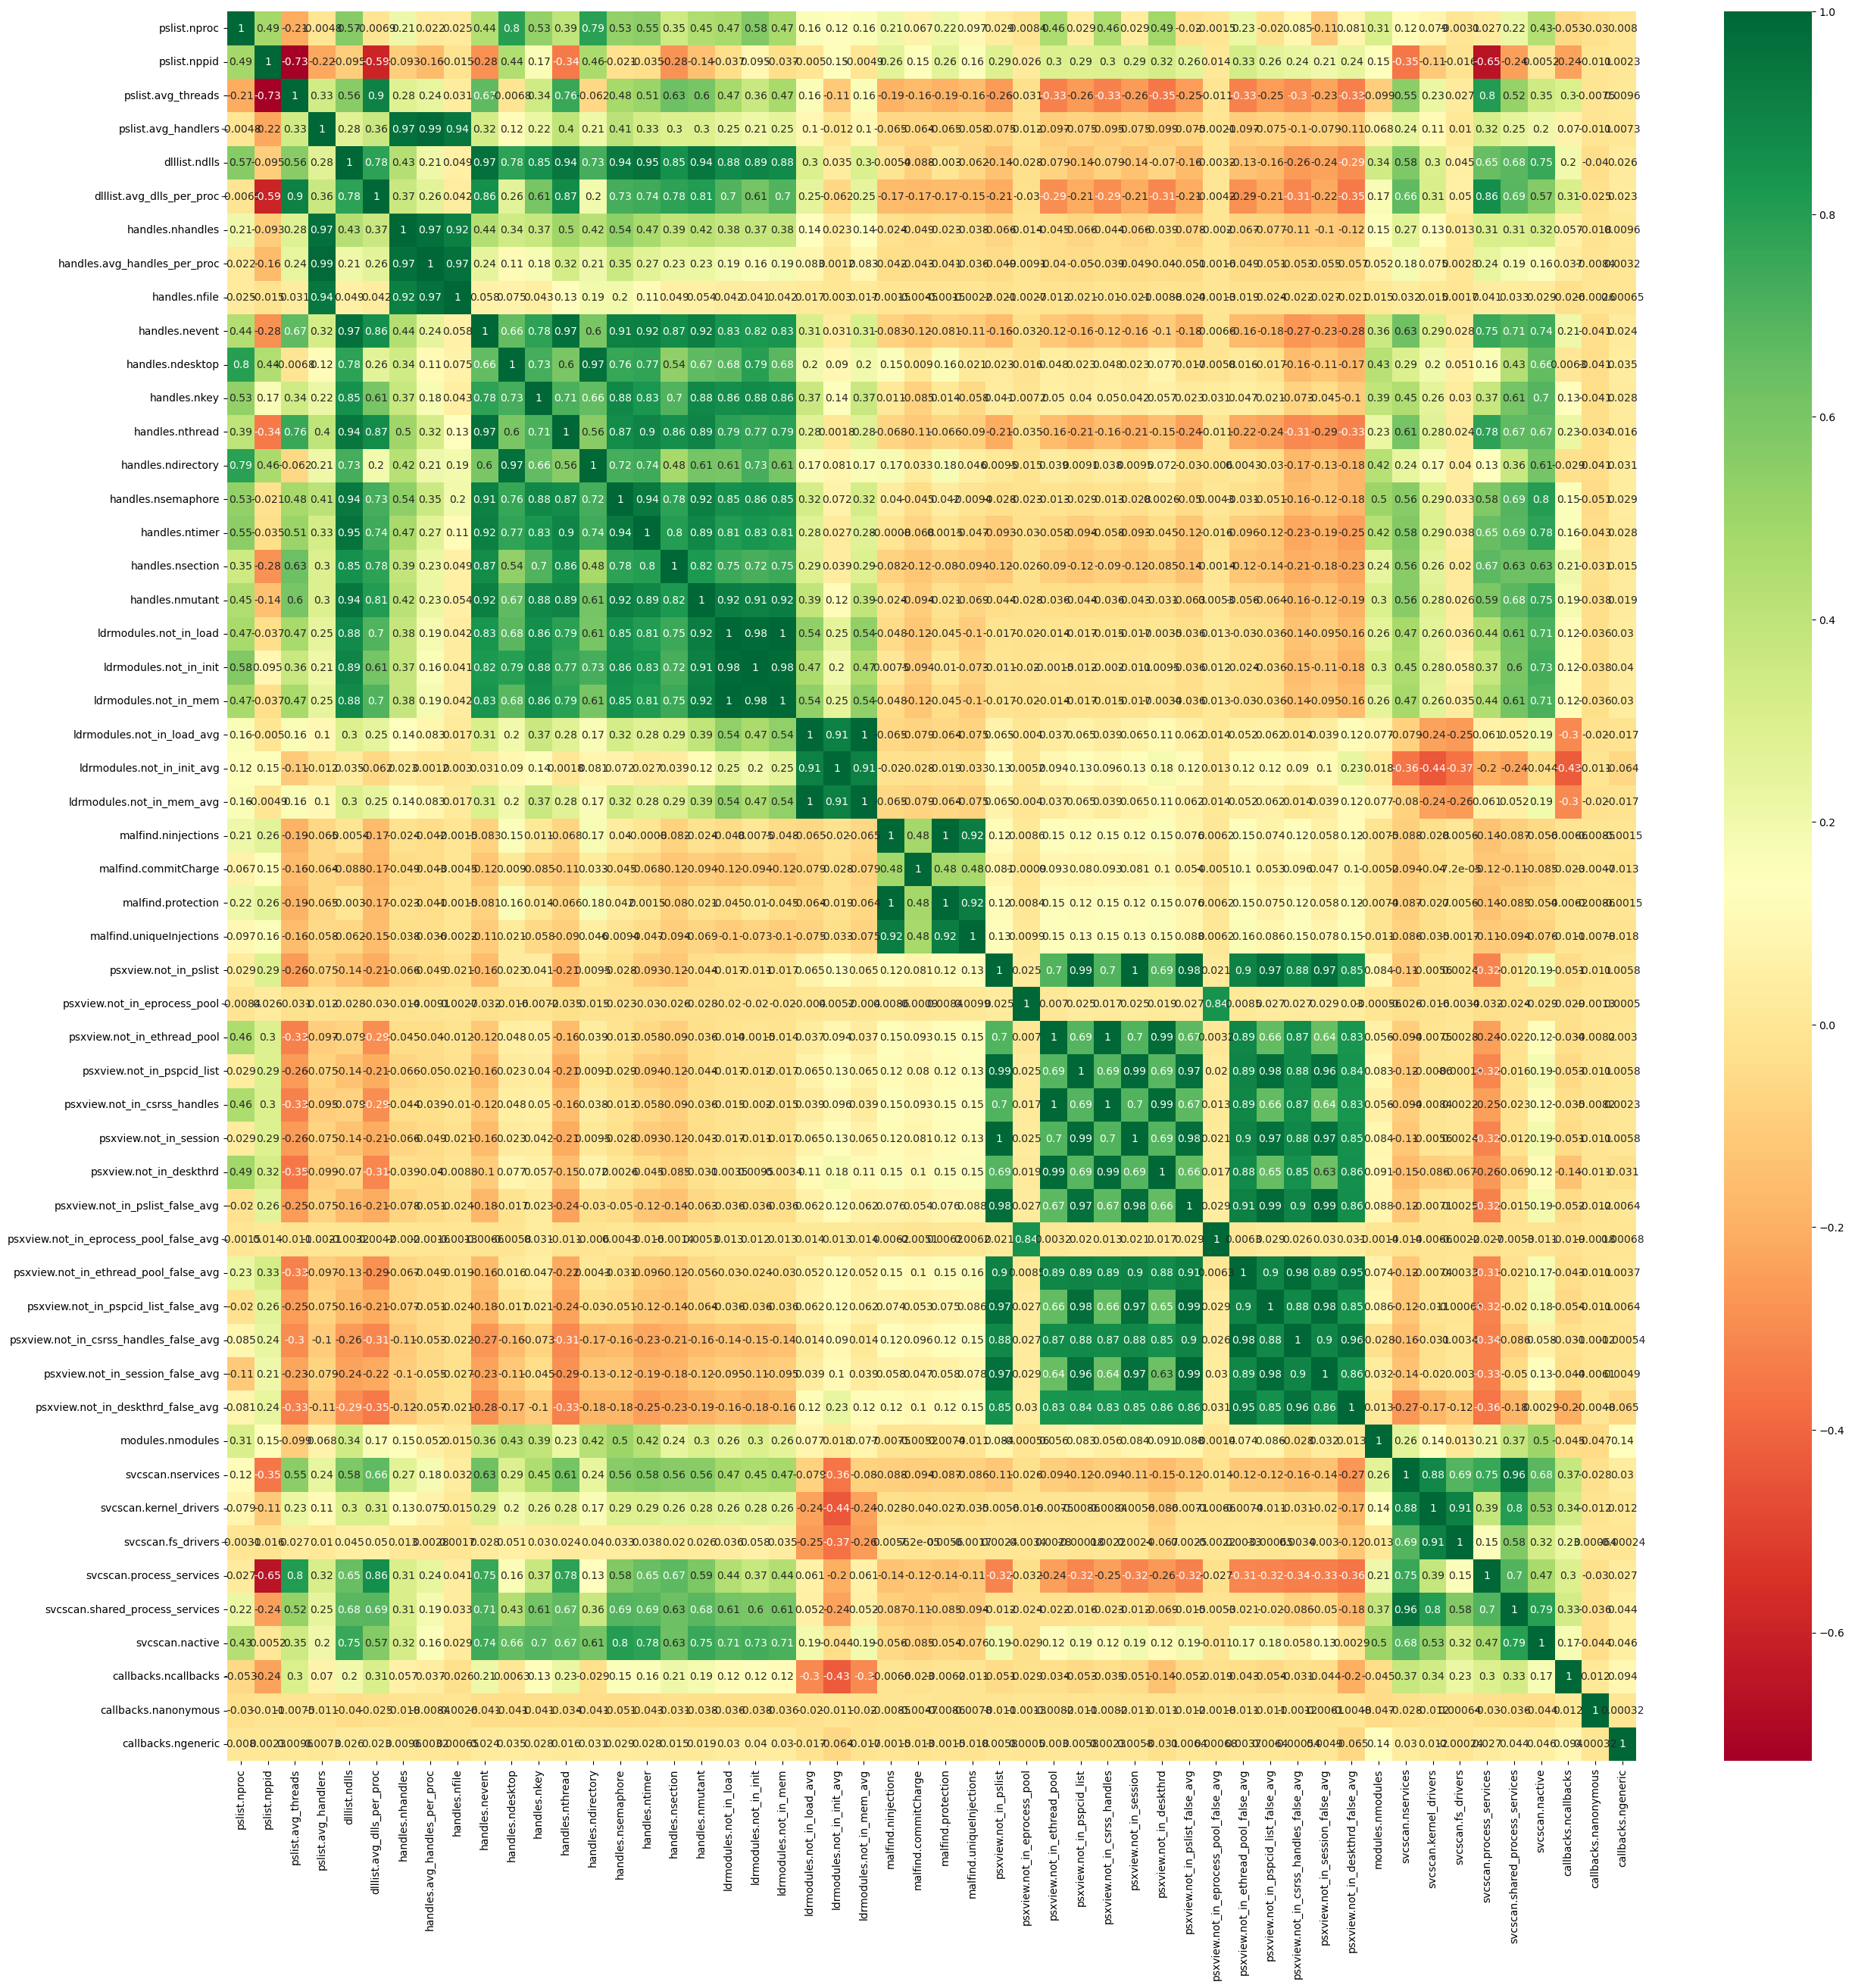

In [19]:
#Looking at the correlated features for future feature reduction
corrmat=dataset.drop(["Category","Class", "Family"],axis=1).corr()
top_corr_feats=corrmat.index
plt.figure(figsize=(30,30))
g= sns.heatmap(dataset[top_corr_feats].corr(), annot=True, cmap="RdYlGn")

---------------------------

## Unsupervised Clustering

### Removing correlated features

In [23]:
dataset1= dataset.copy()
dataset1.drop(["Category","Class", "Family"], axis=1, inplace= True)

corr_features=correlation(dataset1, 0.7)
dataset1.drop(corr_features, axis=1, inplace= True)
FeaturesCorr=dataset1.columns
dataset1["Category"]= dataset.Category
dataset1["Class"]= dataset.Class
dataset1["Family"]= dataset.Family

In [24]:
dataset1

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0                45            17           202.844444           1694   
1                47            19           242.234043           2074   
2                40            14           288.225000           1932   
3                32            13           264.281250           1445   
4                42            16           281.333333           2067   
...             ...           ...                  ...            ...   
58591            37            15           215.486487           1453   
58592            37            14           190.216216           1347   
58593            38            15           210.026316           1448   
58594            37            15           215.513513           1452   
58595            38            15           213.026316           1487   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                        0.030372                    5                    21   
1                        0.036167                   12                    77   
2                        0.026114                    5                     6   
3                        0.021483                    2                     2   
4                        0.047820                   12                    77   
...                           ...                  ...                   ...   
58591                    0.029292                    3                     3   
58592                    0.030958                    3                     3   
58593                    0.029292                    3                     3   
58594                    0.029392                    3                     3   
58595                    0.029255                    3                     3   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                          2                             0               138   
1                          0                             0               138   
2                          0                             0               137   
3                          0                             0               138   
4                          4                             0               138   
...                      ...                           ...               ...   
58591                      1                             0               138   
58592                      0                             0               138   
58593                      2                             0               138   
58594                      0                             0               138   
58595                      3                             0               138   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0                    389                    87                     0   
1                    392                    87                     0   
2                    395                    88                     0   
3                    395                    88                     0   
4                    392                    87                     0   
...                  ...                   ...                   ...   
58591                389                    86                     0   
58592                389                    88                     0   
58593                389                    88                     0   
58594                389                    87                     0   
58595                389                    86                     0   

       callbacks.ngeneric    Category    Class  Family  
0                       8      Benign   Benign  Benign  
1                       8      Benign   Benign  Benign  
2                       8      Benign   Benign  Benign  
3                       8      Benign   Benign  Benign  
4                       8      Benign   Benign  Benign  
.

### Reducing data to 2 dimensions

In [34]:
from umap import UMAP
import umap
import umap.plot
from sklearn.manifold import TSNE

In [25]:
X2D = dataset1.drop(["Category","Class","Family"], axis= 1)

In [32]:
raw = umap.UMAP(
  n_components=2, n_neighbors=2).fit(X2D)

Graph is not fully connected, spectral embedding may not work as expected.


KeyboardInterrupt: 

<AxesSubplot:>

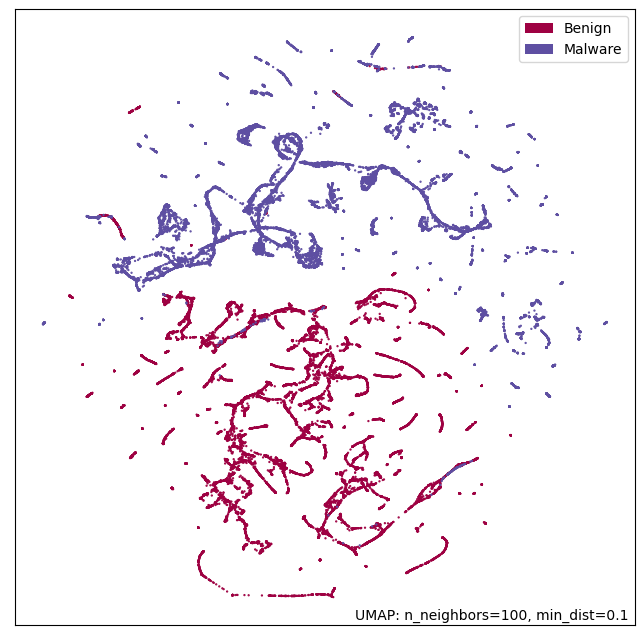

In [31]:
umap.plot.points(raw,labels=dataset1.Class)

In [43]:
tsne=TSNE(n_components=2, perplexity= 100, learning_rate=5000)

In [44]:
rawteste=tsne.fit_transform(X2D)

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.


In [61]:
rawdata = np.array(rawteste)
rawdata= pd.DataFrame(rawdata, columns=["x", "y"])
rawdata["Category"]= dataset.Category
rawdata["Class"]= dataset.Class
rawdata["Family"]= dataset.Family
rawdata 

ValueError: Shape of passed values is (58596, 5), indices imply (58596, 2)

In [63]:
rawdata =rawteste

In [64]:
rawdata

x          y    Category    Class  Family
0     -71.403976  -3.105641      Benign   Benign  Benign
1     -88.633270  18.830532      Benign   Benign  Benign
2     -35.005150  21.546955      Benign   Benign  Benign
3      93.179550 -36.225204      Benign   Benign  Benign
4     -81.412018  31.275789      Benign   Benign  Benign
...          ...        ...         ...      ...     ...
58591  66.749733 -54.124447  Ransomware  Malware   Shade
58592  52.792469  -7.667542  Ransomware  Malware   Shade
58593  35.924133 -24.332787  Ransomware  Malware   Shade
58594  63.126308 -50.180790  Ransomware  Malware   Shade
58595  22.663551  -5.018129  Ransomware  Malware   Shade

[58596 rows x 5 columns]

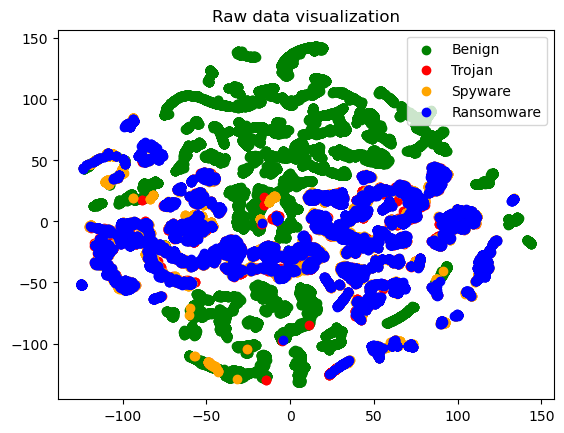

In [51]:
plt.scatter(rawdata[rawdata.Category=="Benign"]["x"], rawdata[rawdata.Category=="Benign"]["y"], color="green",label= "Benign")
plt.scatter(rawdata[rawdata.Category=="Trojan"]["x"], rawdata[rawdata.Category=="Trojan"]["y"], color= "red", label="Trojan")
plt.scatter(rawdata[rawdata.Category=="Spyware"]["x"], rawdata[rawdata.Category=="Spyware"]["y"], color="orange",label= "Spyware")
plt.scatter(rawdata[rawdata.Category=="Ransomware"]["x"], rawdata[rawdata.Category=="Ransomware"]["y"], color= "blue", label="Ransomware")
plt.title("Raw data visualization")
plt.legend()

### Clustering the data (Malware vs Benign)

In [65]:
datasetCluster2= rawdata.copy()

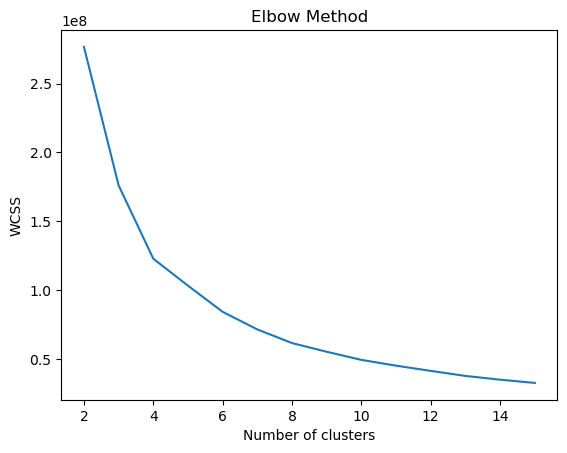

In [67]:
wcss = []

for i in range(2, 16):
    
    model =KMeans(n_clusters=i)
    model.fit(datasetCluster2[["x", "y"]])
    wcss.append(model.inertia_)
plt.plot(range(2, 16), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
#the elbow method shows that the optimum number of cluster should be between 6 and 8 clusters

In [68]:
kmeans2=KMeans(n_clusters=2, random_state=1)
y2_pred=kmeans2.fit_predict(datasetCluster2[["x", "y"]])

In [70]:
datasetCluster2["Cluster"]=y2_pred
datasetCluster2

x          y    Category    Class  Family  Cluster
0     -71.403976  -3.105641      Benign   Benign  Benign        0
1     -88.633270  18.830532      Benign   Benign  Benign        0
2     -35.005150  21.546955      Benign   Benign  Benign        0
3      93.179550 -36.225204      Benign   Benign  Benign        1
4     -81.412018  31.275789      Benign   Benign  Benign        0
...          ...        ...         ...      ...     ...      ...
58591  66.749733 -54.124447  Ransomware  Malware   Shade        1
58592  52.792469  -7.667542  Ransomware  Malware   Shade        1
58593  35.924133 -24.332787  Ransomware  Malware   Shade        1
58594  63.126308 -50.180790  Ransomware  Malware   Shade        1
58595  22.663551  -5.018129  Ransomware  Malware   Shade        1

[58596 rows x 6 columns]

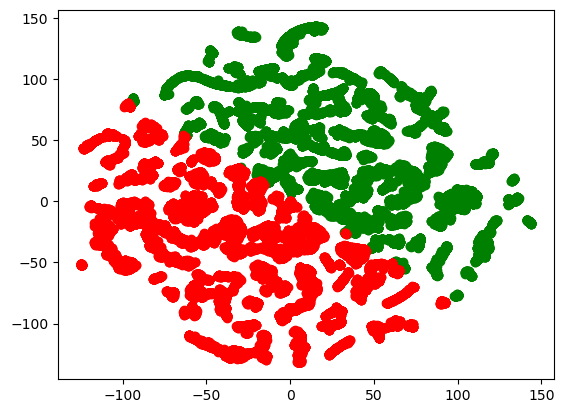

In [72]:
#0 for malware, 1 for benign
#green for benign, red for malware
Cluster1= datasetCluster2[datasetCluster2.Cluster==1]
Cluster0= datasetCluster2[datasetCluster2.Cluster==0]

plt.scatter(Cluster1["x"], Cluster1["y"], color="green")
plt.scatter(Cluster0["x"], Cluster0["y"], color="red")

In [76]:
print("Cluster 0: \n",datasetCluster2[datasetCluster2.Cluster==0].Class.value_counts(), "\n")
print("Cluster 1: \n",datasetCluster2[datasetCluster2.Cluster==1].Class.value_counts())

Cluster 0: 
 Malware    17844
Benign     11979
Name: Class, dtype: int64 

Cluster 1: 
 Benign     17319
Malware    11454
Name: Class, dtype: int64


In [79]:
accuracy0MalwareClass(datasetCluster2)

Accuracy: 60.00921564611919 % 
 False Positive rate: 39.094818758959654 %


Boolean Series key will be reindexed to match DataFrame index.


In [81]:
#Creating two datasets, one for the malware, other for the benign
Malware=datasetCluster2[datasetCluster2.Class== "Malware"]
Benign = datasetCluster2[datasetCluster2.Class== "Benign"]

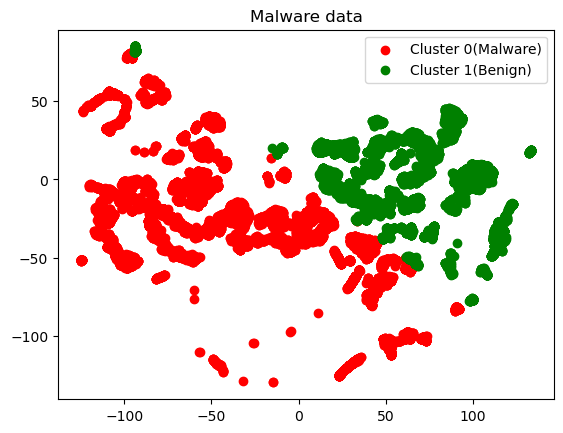

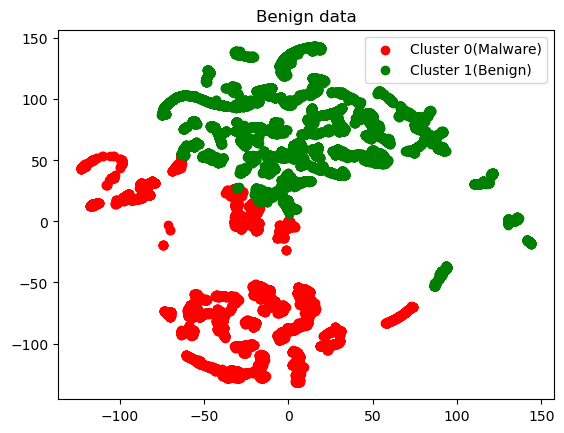

In [82]:
#Scatter plot to visualize the distribution of the malware data among the two clusters
plt.scatter(Malware[Malware.Cluster==0]["x"], Malware[Malware.Cluster==0]["y"], color="red")
plt.scatter(Malware[Malware.Cluster==1]["x"], Malware[Malware.Cluster==1]["y"], color="green")
plt.title("Malware data")
plt.legend(["Cluster 0(Malware)", "Cluster 1(Benign)"])
plt.show()

#Scatter plot to visualize the distribution of the benign data among the two clusters
plt.scatter(Benign[Benign.Cluster==0]["x"], Benign[Benign.Cluster==0]["y"], color="red")
plt.scatter(Benign[Benign.Cluster==1]["x"], Benign[Benign.Cluster==1]["y"], color="green")
plt.title("Benign data")
plt.legend(["Cluster 0(Malware)", "Cluster 1(Benign)"])
plt.show()

### Clustering the data (Malware types)

In [84]:
datasetCluster4= rawdata.copy()

In [85]:
datasetCluster4


x          y    Category    Class  Family
0     -71.403976  -3.105641      Benign   Benign  Benign
1     -88.633270  18.830532      Benign   Benign  Benign
2     -35.005150  21.546955      Benign   Benign  Benign
3      93.179550 -36.225204      Benign   Benign  Benign
4     -81.412018  31.275789      Benign   Benign  Benign
...          ...        ...         ...      ...     ...
58591  66.749733 -54.124447  Ransomware  Malware   Shade
58592  52.792469  -7.667542  Ransomware  Malware   Shade
58593  35.924133 -24.332787  Ransomware  Malware   Shade
58594  63.126308 -50.180790  Ransomware  Malware   Shade
58595  22.663551  -5.018129  Ransomware  Malware   Shade

[58596 rows x 5 columns]

In [86]:
kmeans4=KMeans(n_clusters=4, random_state=1)
y4_pred=kmeans4.fit_predict(datasetCluster4[["x", "y"]])
datasetCluster4["Cluster"]=y4_pred
datasetCluster4

x          y    Category    Class  Family  Cluster
0     -71.403976  -3.105641      Benign   Benign  Benign        1
1     -88.633270  18.830532      Benign   Benign  Benign        1
2     -35.005150  21.546955      Benign   Benign  Benign        1
3      93.179550 -36.225204      Benign   Benign  Benign        3
4     -81.412018  31.275789      Benign   Benign  Benign        1
...          ...        ...         ...      ...     ...      ...
58591  66.749733 -54.124447  Ransomware  Malware   Shade        3
58592  52.792469  -7.667542  Ransomware  Malware   Shade        3
58593  35.924133 -24.332787  Ransomware  Malware   Shade        3
58594  63.126308 -50.180790  Ransomware  Malware   Shade        3
58595  22.663551  -5.018129  Ransomware  Malware   Shade        3

[58596 rows x 6 columns]

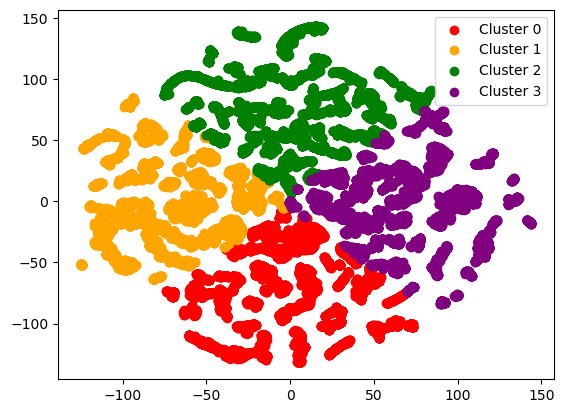

In [87]:
Cluster40= datasetCluster4[datasetCluster4.Cluster==0]
Cluster41= datasetCluster4[datasetCluster4.Cluster==1]
Cluster42= datasetCluster4[datasetCluster4.Cluster==2]
Cluster43= datasetCluster4[datasetCluster4.Cluster==3]

plt.scatter(Cluster40["x"], Cluster40["y"], color="red", label="Cluster 0")
plt.scatter(Cluster41["x"], Cluster41["y"], color="orange", label="Cluster 1")
plt.scatter(Cluster42["x"], Cluster42["y"], color="green", label="Cluster 2")
plt.scatter(Cluster43["x"], Cluster43["y"], color="purple", label="Cluster 3")
plt.legend()

In [91]:
datasetCluster4[datasetCluster4.Cluster==3].Category.value_counts()

Ransomware    4144
Spyware       4109
Trojan        3649
Benign        2616
Name: Category, dtype: int64

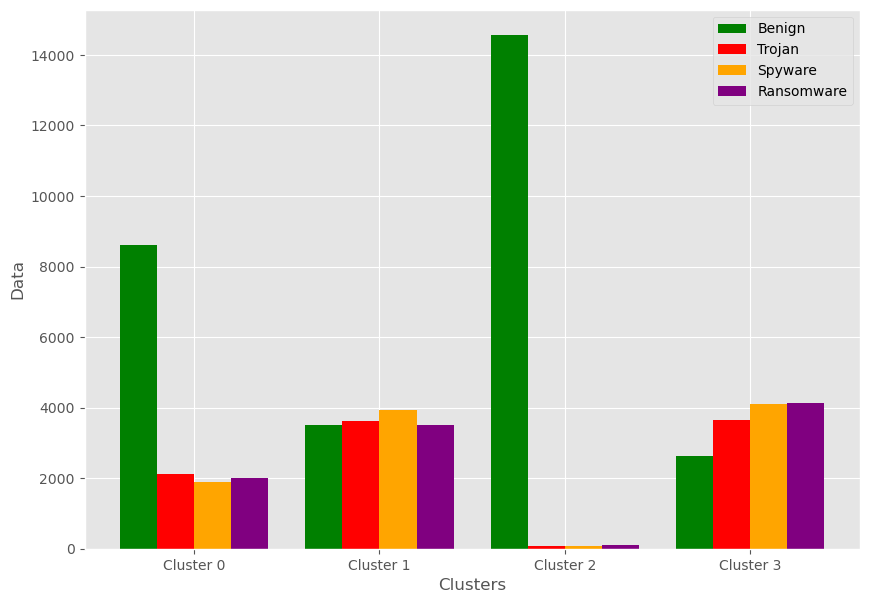

In [92]:
# cluster 0, cluster 1, cluster 2, cluster 3
benign=[8621,3509,14552,2616]
trojan=[2125,3627,86, 3649]
spyware=[1878,3944,89, 4109]
ransomware=[2017,3513,117, 4144]
xpos=np.arange(len(benign))

style.use("ggplot")
plt.figure(figsize=(10,7))
barwidth=0.2
plt.bar(xpos,benign, color='green', width= barwidth, label="Benign")
plt.bar(xpos+0.2,trojan, color='red', width= barwidth, label="Trojan")
plt.bar(xpos+0.4,spyware, color='orange', width= barwidth, label="Spyware")
plt.bar(xpos+0.6,ransomware, color='purple', width= barwidth, label="Ransomware")
plt.xlabel("Clusters")
plt.xticks(xpos+0.3,("Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"))
plt.ylabel("Data")
plt.legend()


### Clustering the data(all malware families)

In [93]:
datasetCluster16= rawdata.copy()

In [96]:
kmeans16=KMeans(n_clusters=16, random_state=1)
y16_pred=kmeans16.fit_predict(datasetCluster16[["x", "y"]])
datasetCluster16["Cluster"]=y16_pred
datasetCluster16

x          y    Category    Class  Family  Cluster
0     -71.403976  -3.105641      Benign   Benign  Benign        2
1     -88.633270  18.830532      Benign   Benign  Benign        6
2     -35.005150  21.546955      Benign   Benign  Benign       12
3      93.179550 -36.225204      Benign   Benign  Benign       11
4     -81.412018  31.275789      Benign   Benign  Benign        6
...          ...        ...         ...      ...     ...      ...
58591  66.749733 -54.124447  Ransomware  Malware   Shade        3
58592  52.792469  -7.667542  Ransomware  Malware   Shade        5
58593  35.924133 -24.332787  Ransomware  Malware   Shade        5
58594  63.126308 -50.180790  Ransomware  Malware   Shade        3
58595  22.663551  -5.018129  Ransomware  Malware   Shade        5

[58596 rows x 6 columns]

In [103]:
datasetCluster16.Cluster.value_counts()

5     5216
2     4452
10    4265
12    4262
9     4221
3     3961
4     3924
6     3762
8     3693
1     3578
15    3514
13    3404
14    3195
7     2582
11    2544
0     2023
Name: Cluster, dtype: int64

<AxesSubplot:ylabel='Cluster'>

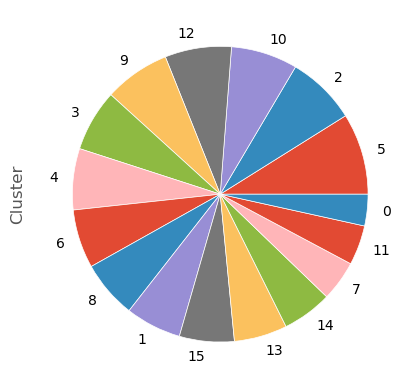

In [102]:
datasetCluster16.Cluster.value_counts().plot.pie(wedgeprops={'edgecolor': 'white'})

Text(0.5, 1.0, 'Clustering 16 families')

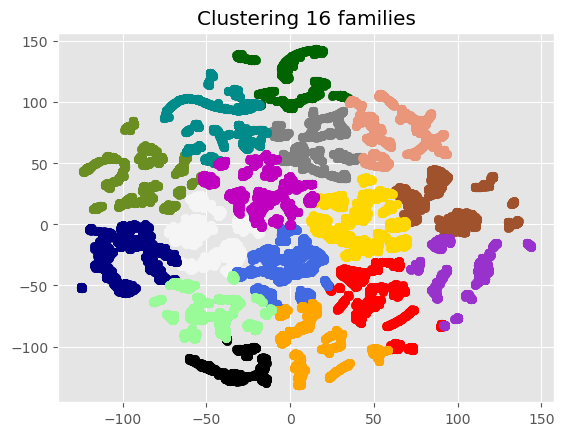

In [101]:
colors=["black","gray","whitesmoke","red","sienna","gold", "olivedrab", "darkgreen", "darkcyan","royalblue", "navy","darkorchid","m","orange","palegreen","darksalmon"]
label=["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3","Cluster 4" ,"Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8", "Cluster 9", "Cluster 10", "Cluster 11","Cluster 12", "Cluster 13", "Cluster 14", "Cluster 15"]
for i in range(len(dataset.Family.unique())):
    plt.scatter(datasetCluster16[datasetCluster16.Cluster== i]["x"],datasetCluster16[datasetCluster16.Cluster== i]["y"], color= colors[i], label= label[i])
#plt.legend()    
plt.title("Clustering 16 families")  

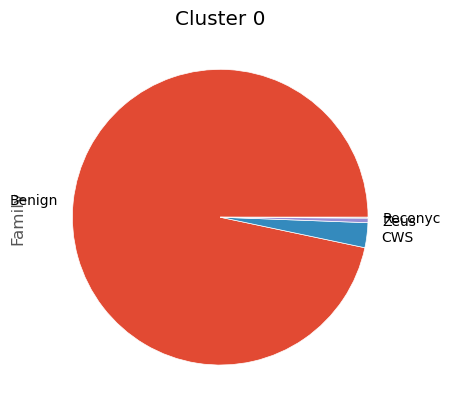

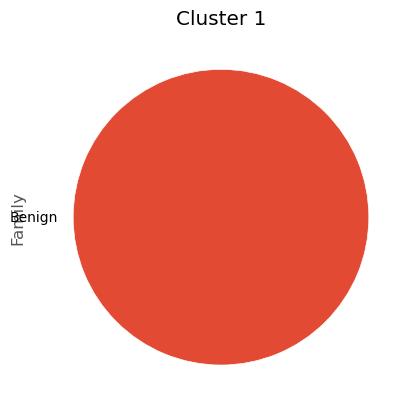

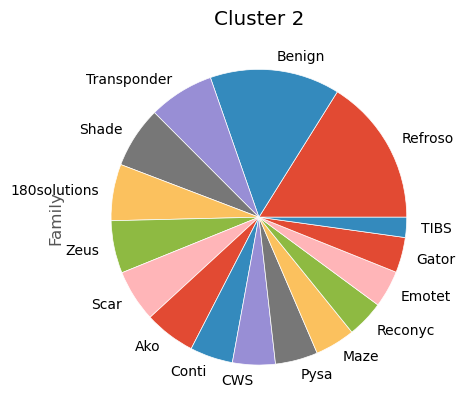

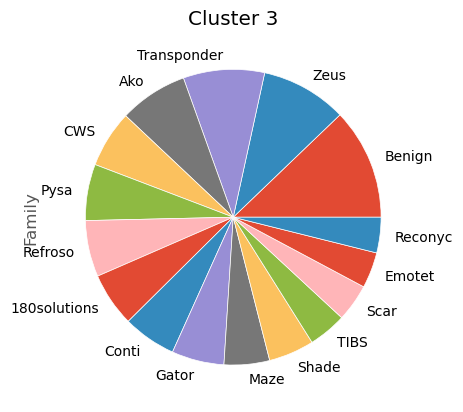

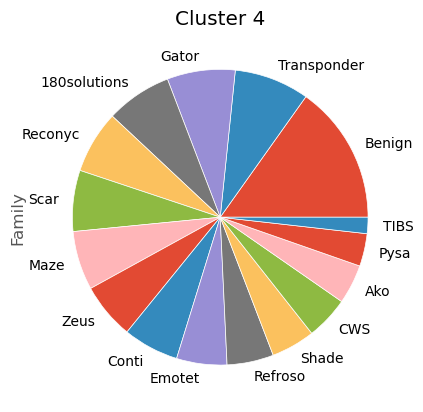

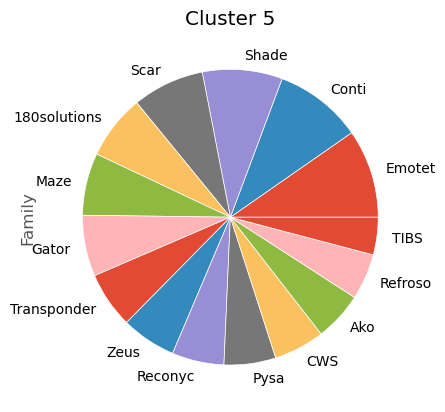

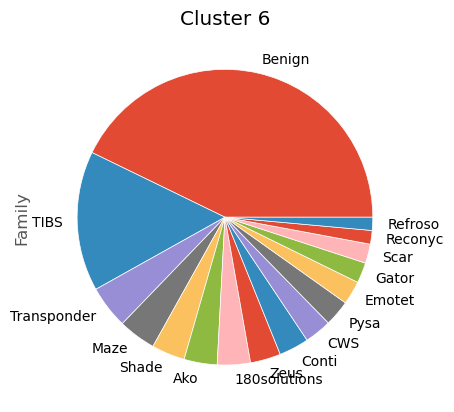

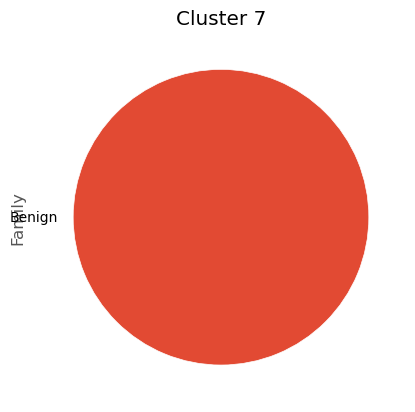

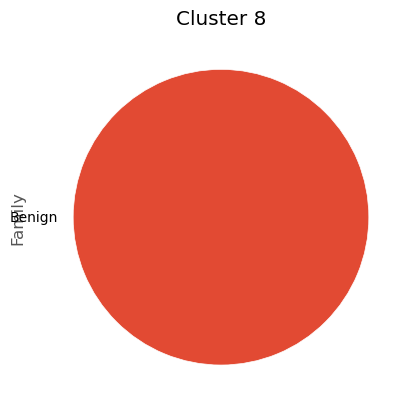

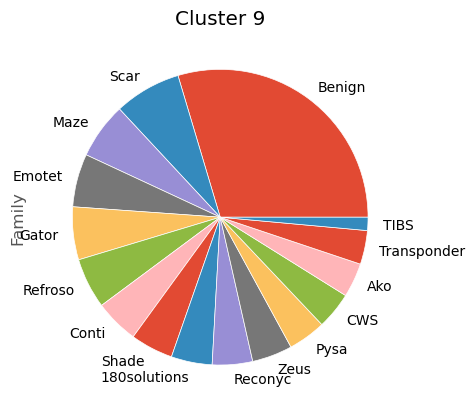

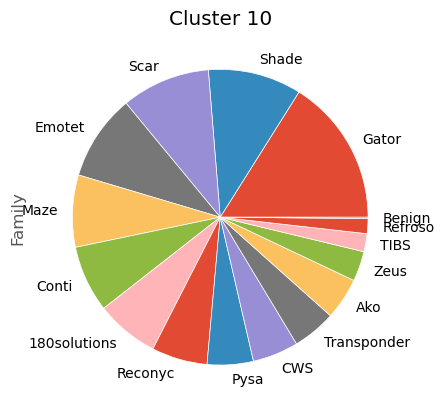

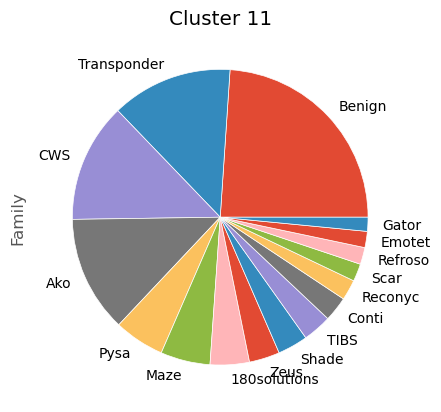

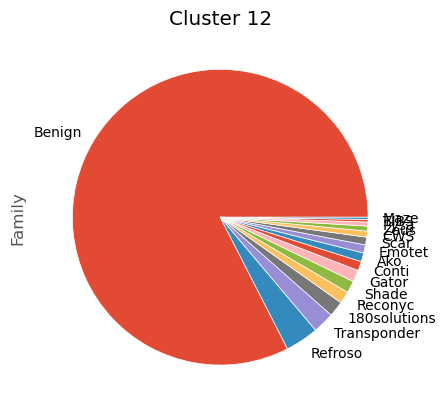

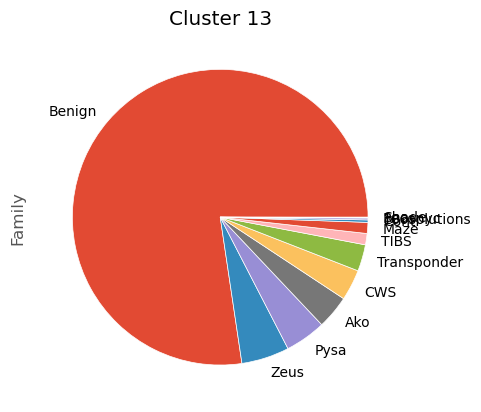

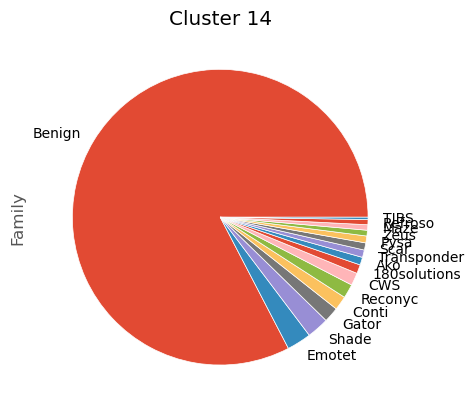

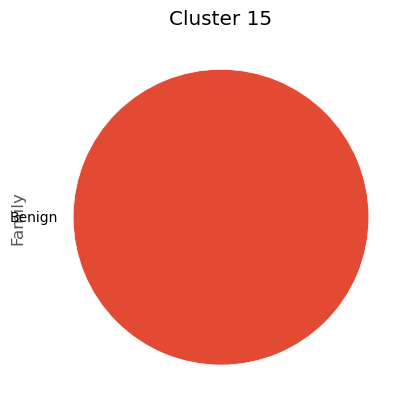

In [106]:
for i in range((len(dataset.Family.unique()))):
    datasetCluster16[datasetCluster16.Cluster==i].Family.value_counts().plot.pie(wedgeprops={'edgecolor': 'white'})
    plt.title(label[i])
    plt.show()


In [ ]:
#test other clusters

## Supervised Clustering

In [111]:
dataset2 = dataset1.copy()
Class = ["Benign", "Malware"] #0,1
Category=['Benign', 'Ransomware', 'Spyware', 'Trojan'] # 0,1,2,3
Family= ['Benign', 'Ako', 'Conti', 'Maze', 'Pysa', 'Shade', '180solutions',
       'CWS', 'Gator', 'TIBS', 'Transponder', 'Emotet', 'Reconyc',
       'Refroso', 'Scar', 'Zeus'] # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
Code1=[0,1]
Code2=[0,1,2,3]
Code3=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

dataset2.Class.replace(Class, Code1, inplace= True)
dataset2.Category.replace(Category, Code2, inplace= True)
dataset2.Family.replace(Family, Code3, inplace= True)


In [112]:
dataset2

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0                45            17           202.844444           1694   
1                47            19           242.234043           2074   
2                40            14           288.225000           1932   
3                32            13           264.281250           1445   
4                42            16           281.333333           2067   
...             ...           ...                  ...            ...   
58591            37            15           215.486487           1453   
58592            37            14           190.216216           1347   
58593            38            15           210.026316           1448   
58594            37            15           215.513513           1452   
58595            38            15           213.026316           1487   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                        0.030372                    5                    21   
1                        0.036167                   12                    77   
2                        0.026114                    5                     6   
3                        0.021483                    2                     2   
4                        0.047820                   12                    77   
...                           ...                  ...                   ...   
58591                    0.029292                    3                     3   
58592                    0.030958                    3                     3   
58593                    0.029292                    3                     3   
58594                    0.029392                    3                     3   
58595                    0.029255                    3                     3   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                          2                             0               138   
1                          0                             0               138   
2                          0                             0               137   
3                          0                             0               138   
4                          4                             0               138   
...                      ...                           ...               ...   
58591                      1                             0               138   
58592                      0                             0               138   
58593                      2                             0               138   
58594                      0                             0               138   
58595                      3                             0               138   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0                    389                    87                     0   
1                    392                    87                     0   
2                    395                    88                     0   
3                    395                    88                     0   
4                    392                    87                     0   
...                  ...                   ...                   ...   
58591                389                    86                     0   
58592                389                    88                     0   
58593                389                    88                     0   
58594                389                    87                     0   
58595                389                    86                     0   

       callbacks.ngeneric  Category  Class  Family  
0                       8         0      0       0  
1                       8         0      0       0  
2                       8         0      0       0  
3                       8         0      0       0  
4                       8         0      0       0  
...                   ...

### Training a xgboost model

In [113]:
X = dataset2.drop(["Category","Class","Family"], axis=1)
Y = dataset2["Class"]

x_train,x_test, y_train,y_test= train_test_split(X, Y, test_size=0.2, random_state=0)

In [114]:
#param optimization for gridsearch
params = {
    "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    "max_depth": [5,10,15,20],
    "min_child_weight": [1,3,5,7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
    "early_stopping_rounds": [25,50,100],
    "n_estimators": [100,200,500]
}

In [115]:
Classifier= xgb.XGBClassifier()
random_search=RandomizedSearchCV(Classifier, param_distributions=params, n_iter=5, n_jobs=-1,cv=5)

In [116]:
start_time=timer(None)
random_search.fit(x_train,y_train, eval_set=[(x_test, y_test)])
timer(start_time)

[0]	validation_0-logloss:0.55945
[1]	validation_0-logloss:0.45580
[2]	validation_0-logloss:0.37626
[3]	validation_0-logloss:0.31636
[4]	validation_0-logloss:0.26499
[5]	validation_0-logloss:0.22340
[6]	validation_0-logloss:0.18966
[7]	validation_0-logloss:0.16122
[8]	validation_0-logloss:0.14047
[9]	validation_0-logloss:0.13349
[10]	validation_0-logloss:0.11426
[11]	validation_0-logloss:0.09763
[12]	validation_0-logloss:0.08389
[13]	validation_0-logloss:0.07224
[14]	validation_0-logloss:0.06202
[15]	validation_0-logloss:0.05477
[16]	validation_0-logloss:0.04916
[17]	validation_0-logloss:0.04261
[18]	validation_0-logloss:0.03693
[19]	validation_0-logloss:0.03221
[20]	validation_0-logloss:0.02782
[21]	validation_0-logloss:0.02427
[22]	validation_0-logloss:0.02128
[23]	validation_0-logloss:0.01873
[24]	validation_0-logloss:0.01643
[25]	validation_0-logloss:0.01429
[26]	validation_0-logloss:0.01260
[27]	validation_0-logloss:0.01106
[28]	validation_0-logloss:0.01014
[29]	validation_0-loglos

In [117]:
random_search.best_params_

{'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.15,
 'gamma': 0.3,
 'early_stopping_rounds': 25,
 'colsample_bytree': 0.3}

In [165]:
#Rebuild our xgboost classifier with optimal parameters
Classifier= xgb.XGBClassifier(n_estimators=100,
 min_child_weight=3,
 max_depth=10,
 learning_rate=0.2,
 gamma=0.4,
 early_stopping_rounds=25,
 colsample_bytree=0.3)
Classifier.fit(x_train,y_train,eval_set=[(x_test, y_test)])

[0]	validation_0-logloss:0.51697
[1]	validation_0-logloss:0.39536
[2]	validation_0-logloss:0.30862
[3]	validation_0-logloss:0.24633
[4]	validation_0-logloss:0.19627
[5]	validation_0-logloss:0.15735
[6]	validation_0-logloss:0.12716
[7]	validation_0-logloss:0.10319
[8]	validation_0-logloss:0.08602
[9]	validation_0-logloss:0.08070
[10]	validation_0-logloss:0.06606
[11]	validation_0-logloss:0.05402
[12]	validation_0-logloss:0.04439
[13]	validation_0-logloss:0.03650
[14]	validation_0-logloss:0.03001
[15]	validation_0-logloss:0.02547
[16]	validation_0-logloss:0.02203
[17]	validation_0-logloss:0.01836
[18]	validation_0-logloss:0.01530
[19]	validation_0-logloss:0.01297
[20]	validation_0-logloss:0.01083
[21]	validation_0-logloss:0.00914
[22]	validation_0-logloss:0.00785
[23]	validation_0-logloss:0.00681
[24]	validation_0-logloss:0.00588
[25]	validation_0-logloss:0.00506
[26]	validation_0-logloss:0.00440
[27]	validation_0-logloss:0.00384
[28]	validation_0-logloss:0.00350
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=25, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [166]:
#Checking accuracy
y_predxgb= Classifier.predict(x_test)
predictions = [round(value) for value in y_predxgb]
accuracy = accuracy_score(y_test, predictions)
accuracy

0.999914675767918

### Computing SHAP values

In [167]:
start_time=timer(None)
explainer = shap.Explainer(Classifier, X, seed=1)
shap_values = explainer(X)
timer(start_time)

 99%|===================| 57838/58596 [00:43<00:00]        


 Time taken: 0 hours 0 minutes and 43 seconds.


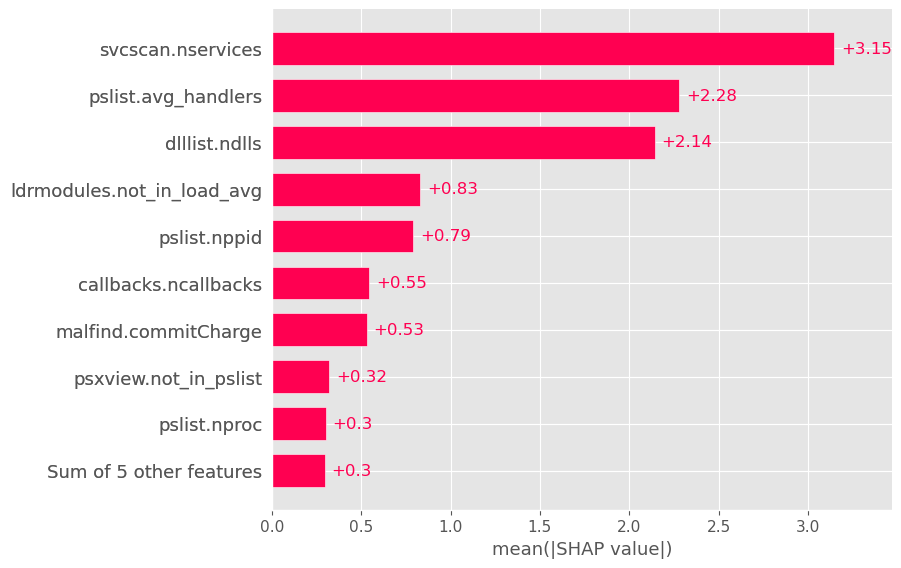

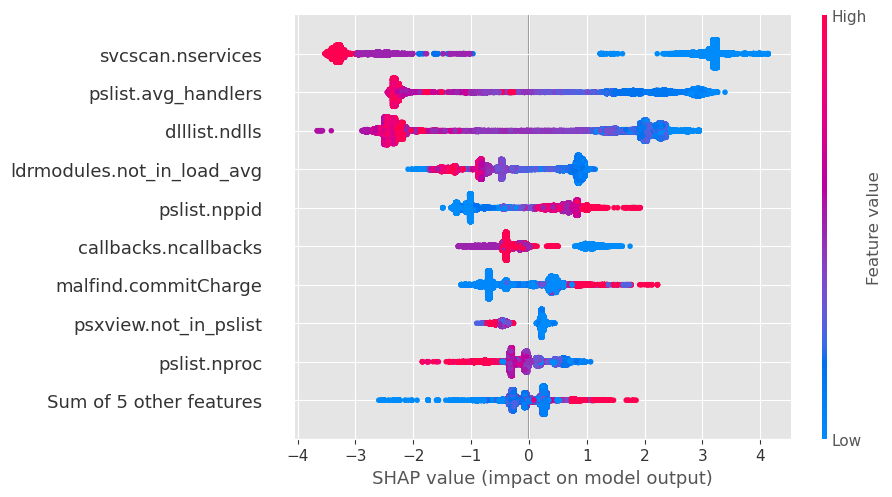

In [168]:
#Visualization of the mean SHAP values
shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)

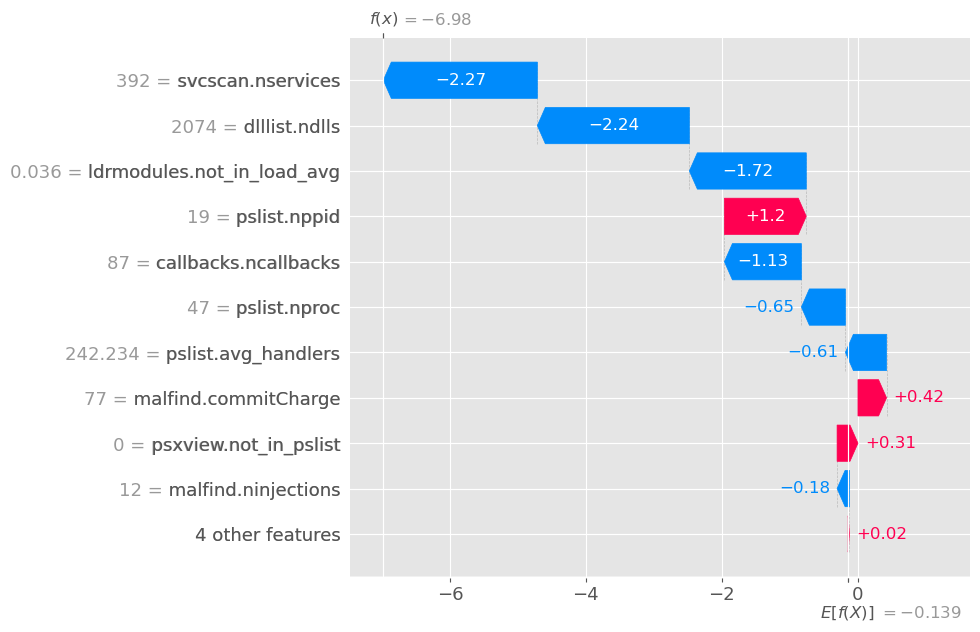

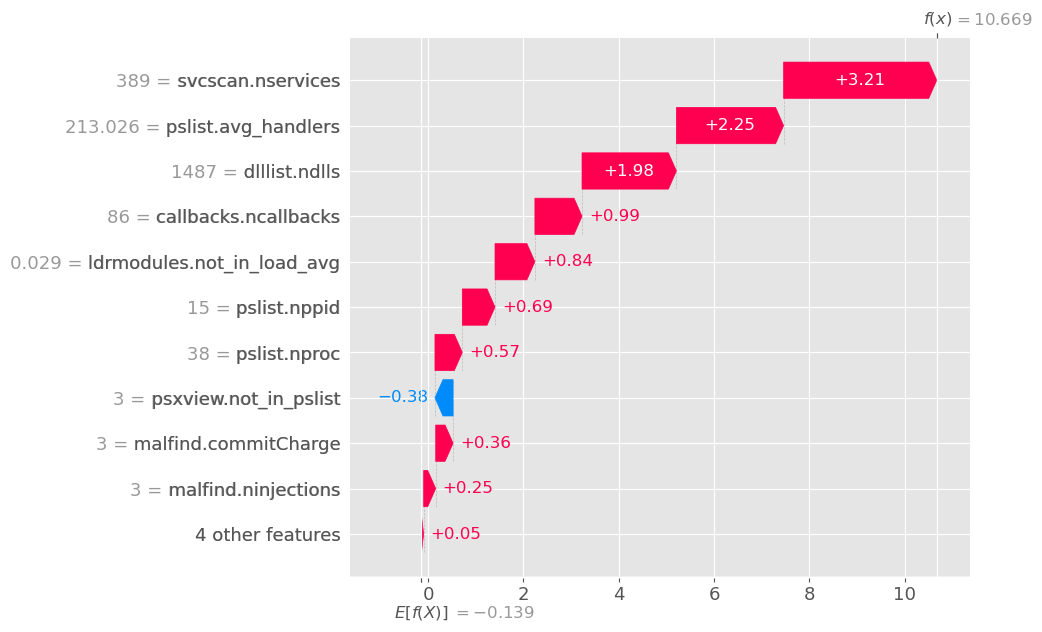

In [169]:
#Visualization of the SHAP values for both 1 malware and 1 benign data
shap.plots.waterfall(shap_values[1], max_display=11)

shap.plots.waterfall(shap_values[58595], max_display=11)

### Reducing SHAP values to 2D

In [125]:
#shaps = umap.UMAP(
  #n_components=2, n_neighbors=200).fit_transform(shap_values.values)

In [265]:
shaps1 = umap.UMAP(
  n_components=2, n_neighbors=10).fit_transform(shap_values.values)

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!


In [266]:
shapsDF= pd.DataFrame(shaps1, columns=["x", "y"])
shapsDF["Category"]= rawdata.Category
shapsDF["Class"]= rawdata.Class

In [267]:
shapsDF

x          y    Category    Class
0      -3.877603  -0.975575      Benign   Benign
1      12.987830  -2.846877      Benign   Benign
2      14.739386   2.901974      Benign   Benign
3      14.784383   0.584313      Benign   Benign
4      12.320617  11.817767      Benign   Benign
...          ...        ...         ...      ...
58591   4.112122   7.180939  Ransomware  Malware
58592  -1.529342   5.314014  Ransomware  Malware
58593   3.280973   2.621747  Ransomware  Malware
58594   1.380349  -8.523162  Ransomware  Malware
58595  -3.454583   7.555564  Ransomware  Malware

[58596 rows x 4 columns]

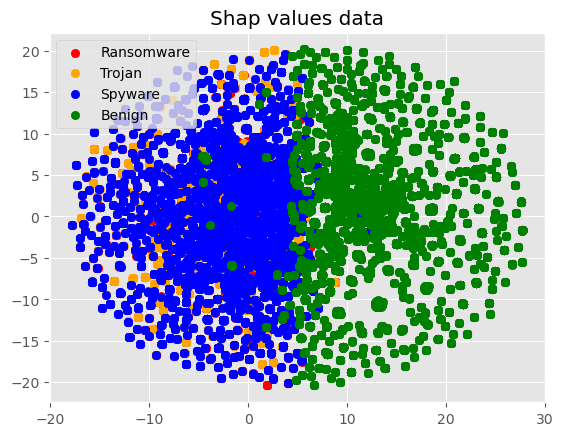

In [268]:
plt.scatter(shapsDF[shapsDF.Category=="Ransomware"]["x"], shapsDF[shapsDF.Category=="Ransomware"]["y"], color= "red", label= "Ransomware")
plt.scatter(shapsDF[shapsDF.Category=="Trojan"]["x"], shapsDF[shapsDF.Category=="Trojan"]["y"], color= "orange", label= "Trojan")
plt.scatter(shapsDF[shapsDF.Category=="Spyware"]["x"], shapsDF[shapsDF.Category=="Spyware"]["y"], color= "blue", label= "Spyware")
#plt.scatter(shapsDF[shapsDF.Class=="Malware"]["x"], shapsDF[shapsDF.Class=="Malware"]["y"], color= "red", label= "Malware")
plt.scatter(shapsDF[shapsDF.Class=="Benign"]["x"], shapsDF[shapsDF.Class=="Benign"]["y"], color= "green", label= "Benign")
plt.title("Shap values data")
plt.legend()

In [269]:
kmeansShap=KMeans(n_clusters=2, random_state=1)

ShapsPred=kmeansShap.fit_predict(shapsDF[["x", "y"]])
shapsDF["Cluster"]=ShapsPred
shapsDF

x          y    Category    Class  Cluster
0      -3.877603  -0.975575      Benign   Benign        0
1      12.987830  -2.846877      Benign   Benign        1
2      14.739386   2.901974      Benign   Benign        1
3      14.784383   0.584313      Benign   Benign        1
4      12.320617  11.817767      Benign   Benign        1
...          ...        ...         ...      ...      ...
58591   4.112122   7.180939  Ransomware  Malware        0
58592  -1.529342   5.314014  Ransomware  Malware        0
58593   3.280973   2.621747  Ransomware  Malware        0
58594   1.380349  -8.523162  Ransomware  Malware        0
58595  -3.454583   7.555564  Ransomware  Malware        0

[58596 rows x 5 columns]

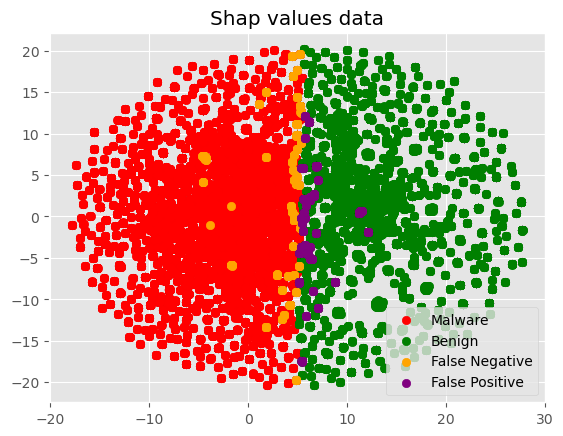

In [270]:
plt.scatter(shapsDF[shapsDF.Cluster==0]["x"],shapsDF[shapsDF.Cluster==0]["y"], color="red", label="Malware")
plt.scatter(shapsDF[shapsDF.Cluster==1]["x"],shapsDF[shapsDF.Cluster==1]["y"], color="green", label="Benign")
plt.scatter(shapsDF[(shapsDF.Cluster==0) & (shapsDF.Class== "Benign")]["x"],shapsDF[(shapsDF.Cluster==0) & (shapsDF.Class== "Benign")]["y"], color= "orange", label ="False Negative")
plt.scatter(shapsDF[(shapsDF.Cluster==1) & (shapsDF.Class== "Malware")]["x"],shapsDF[(shapsDF.Cluster==1) & (shapsDF.Class== "Malware")]["y"], color= "purple", label ="False Positive")
plt.title("Shap values data")
plt.legend()

In [271]:
accuracy0MalwareClass(shapsDF)

Accuracy: 97.21482695064509 % 
 False Positive rate: 2.5735545088401937 %


Boolean Series key will be reindexed to match DataFrame index.


### Training a xgboost model (Ransomware x Trojan x Spyware vs Benign)

In [272]:
#0 for benign, 1 for ransomware, 2 for spyware, 3 for Trojan
X1 = dataset2.drop(["Category","Class","Family"], axis=1)
Y1 = dataset2["Category"]

x1_train,x1_test, y1_train,y1_test= train_test_split(X1, Y1, test_size=0.2, random_state=0)

In [273]:
#param optimization for gridsearch
params1 = {
    "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    "max_depth": [10,15,20,30,50],
    "min_child_weight": [1,3,5,7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
    "early_stopping_rounds": [25,50,100],
    "n_estimators": [100,200,500]
}

In [274]:
Classifier1= xgb.XGBClassifier()
random_search1=RandomizedSearchCV(Classifier1, param_distributions=params1, n_iter=5, n_jobs=-1,cv=5)

In [275]:
start_time=timer(None)
random_search1.fit(x1_train,y1_train, eval_set=[(x1_test, y1_test)])
timer(start_time)

[0]	validation_0-mlogloss:1.14466
[1]	validation_0-mlogloss:0.98209
[2]	validation_0-mlogloss:0.86169
[3]	validation_0-mlogloss:0.76258
[4]	validation_0-mlogloss:0.68376
[5]	validation_0-mlogloss:0.62502
[6]	validation_0-mlogloss:0.57685
[7]	validation_0-mlogloss:0.53844
[8]	validation_0-mlogloss:0.50448
[9]	validation_0-mlogloss:0.48010
[10]	validation_0-mlogloss:0.45782
[11]	validation_0-mlogloss:0.43931
[12]	validation_0-mlogloss:0.42414
[13]	validation_0-mlogloss:0.41191
[14]	validation_0-mlogloss:0.40177
[15]	validation_0-mlogloss:0.39299
[16]	validation_0-mlogloss:0.38553
[17]	validation_0-mlogloss:0.37963
[18]	validation_0-mlogloss:0.37433
[19]	validation_0-mlogloss:0.37021
[20]	validation_0-mlogloss:0.36624
[21]	validation_0-mlogloss:0.36247
[22]	validation_0-mlogloss:0.35985
[23]	validation_0-mlogloss:0.35756
[24]	validation_0-mlogloss:0.35559
[25]	validation_0-mlogloss:0.35368
[26]	validation_0-mlogloss:0.35223
[27]	validation_0-mlogloss:0.35148
[28]	validation_0-mlogloss:0.3

In [276]:
random_search1.best_params_

{'n_estimators': 500,
 'min_child_weight': 7,
 'max_depth': 20,
 'learning_rate': 0.2,
 'gamma': 0.4,
 'early_stopping_rounds': 50,
 'colsample_bytree': 0.7}

In [277]:
Classifier1= xgb.XGBClassifier(n_estimators=500,
 min_child_weight=7,
 max_depth=20,
 learning_rate=0.2,
 gamma=0.4,
 early_stopping_rounds=50,
 colsample_bytree=0.7)
Classifier1.fit(x1_train,y1_train,eval_set=[(x1_test, y1_test)])

[0]	validation_0-mlogloss:1.14466
[1]	validation_0-mlogloss:0.98209
[2]	validation_0-mlogloss:0.86169
[3]	validation_0-mlogloss:0.76258
[4]	validation_0-mlogloss:0.68376
[5]	validation_0-mlogloss:0.62502
[6]	validation_0-mlogloss:0.57685
[7]	validation_0-mlogloss:0.53844
[8]	validation_0-mlogloss:0.50448
[9]	validation_0-mlogloss:0.48010
[10]	validation_0-mlogloss:0.45782
[11]	validation_0-mlogloss:0.43931
[12]	validation_0-mlogloss:0.42414
[13]	validation_0-mlogloss:0.41191
[14]	validation_0-mlogloss:0.40177
[15]	validation_0-mlogloss:0.39299
[16]	validation_0-mlogloss:0.38553
[17]	validation_0-mlogloss:0.37963
[18]	validation_0-mlogloss:0.37433
[19]	validation_0-mlogloss:0.37021
[20]	validation_0-mlogloss:0.36624
[21]	validation_0-mlogloss:0.36247
[22]	validation_0-mlogloss:0.35985
[23]	validation_0-mlogloss:0.35756
[24]	validation_0-mlogloss:0.35559
[25]	validation_0-mlogloss:0.35368
[26]	validation_0-mlogloss:0.35223
[27]	validation_0-mlogloss:0.35148
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [278]:
y_predxgb1= Classifier1.predict(x1_test)
predictions1 = [round(value) for value in y_predxgb1]
accuracy1 = accuracy_score(y1_test, predictions1)
accuracy1

0.8472696245733788

In [343]:
start_time=timer(None)
explainer1 = shap.Explainer(Classifier1, X1, seed=1)
shap_values1 = explainer1(X1)
timer(start_time)

100%|===================| 175666/175788 [21:40<00:00]        


 Time taken: 0 hours 21 minutes and 44 seconds.


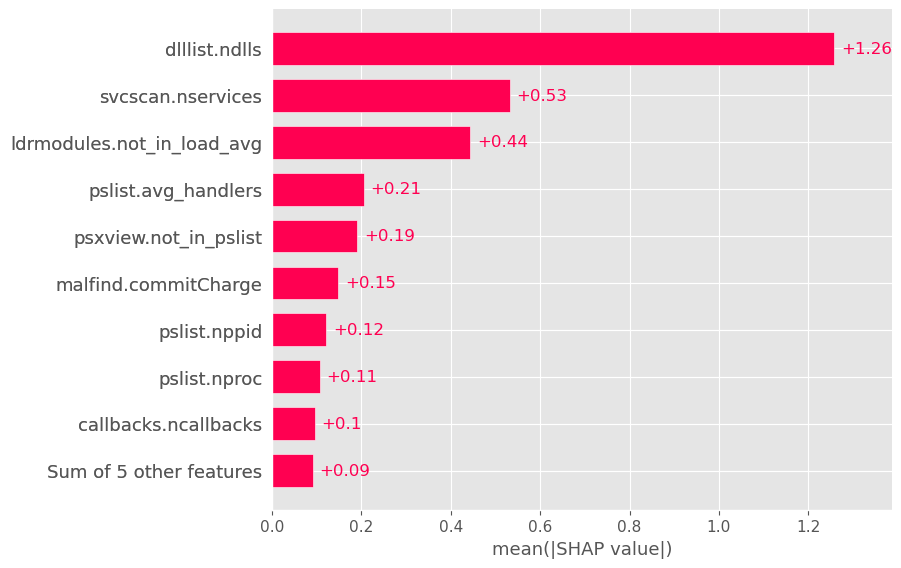

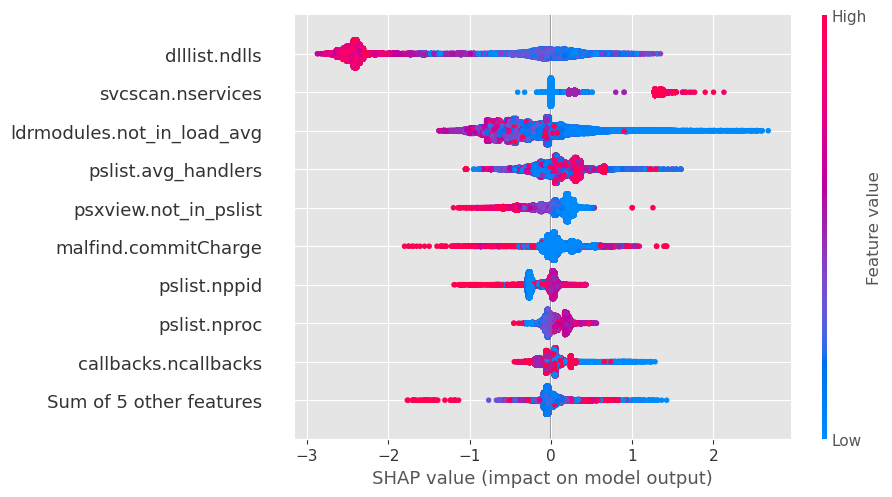

In [347]:
shap.plots.bar(shap_values1[:,:,0])

shap.plots.beeswarm(shap_values1[:,:,0])

In [382]:
ShapBenign=shap_values1[:, :, 1].values
ShapBenign =np.array(ShapBenign)
ShapBenign = pd.DataFrame(ShapBenign, columns= X2.columns)

In [383]:
ShapBenign = umap.UMAP(
  n_components=2, n_neighbors=20).fit_transform(ShapBenign)

In [384]:
BenignDF= pd.DataFrame(ShapBenign, columns=["x", "y"])
BenignDF["Category"]= dataset2.Category
BenignDF["Class"]= dataset2.Class
BenignDF

x          y  Category  Class
0      -3.338691   7.049579         0      0
1       2.107020  22.281572         0      0
2      12.724541  -2.255994         0      0
3       1.806930  -5.970707         0      0
4      15.287192  10.007114         0      0
...          ...        ...       ...    ...
58591   8.119422  -2.652251         1      1
58592   0.830806   5.959499         1      1
58593   5.497776  10.204320         1      1
58594   1.026034  -1.268891         1      1
58595  -2.616336   3.465468         1      1

[58596 rows x 4 columns]

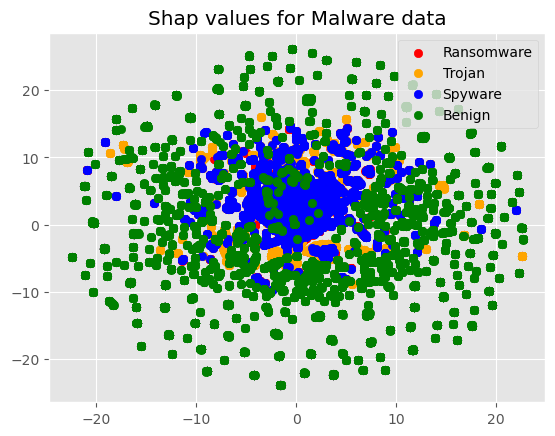

In [385]:
plt.scatter(BenignDF[BenignDF.Category==1]["x"], BenignDF[BenignDF.Category==1]["y"], color= "red", label= "Ransomware")
plt.scatter(BenignDF[BenignDF.Category==2]["x"], BenignDF[BenignDF.Category==2]["y"], color= "orange", label= "Trojan")
plt.scatter(BenignDF[BenignDF.Category==3]["x"], BenignDF[BenignDF.Category==3]["y"], color= "blue", label= "Spyware")
#plt.scatter(BenignDF[BenignDF.Class==1]["x"], BenignDF[BenignDF.Class==1]["y"], color= "red", label= "Malware")
plt.scatter(BenignDF[BenignDF.Class==0]["x"], BenignDF[BenignDF.Class==0]["y"], color= "green", label= "Benign")
plt.title("Shap values for Malware data")
plt.legend()

### Train a xgboost model(Ransomware x Trojan x Spyware)

In [283]:
# 0- Benign, 1- Rnasomware, 2 - Spyware, 3- Trojan
MalwareDataSet = dataset2.copy()
MalwareDataSet= MalwareDataSet[MalwareDataSet.Class!= 0]

In [284]:
MalwareDataSet

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
29298            39            15           220.589744           1562   
29299            37            15           214.648649           1445   
29300            39            15           217.410256           1551   
29301            41            16           210.170732           1614   
29302            40            16           208.650000           1556   
...             ...           ...                  ...            ...   
58591            37            15           215.486487           1453   
58592            37            14           190.216216           1347   
58593            38            15           210.026316           1448   
58594            37            15           215.513513           1452   
58595            38            15           213.026316           1487   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
29298                    0.029229                    3                     3   
29299                    0.028826                    3                     3   
29300                    0.029430                    3                     3   
29301                    0.027728                    3                     3   
29302                    0.028160                    3                     3   
...                           ...                  ...                   ...   
58591                    0.029292                    3                     3   
58592                    0.030958                    3                     3   
58593                    0.029292                    3                     3   
58594                    0.029392                    3                     3   
58595                    0.029255                    3                     3   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
29298                      4                             0               138   
29299                      0                             0               138   
29300                      4                             0               138   
29301                      4                             0               138   
29302                      5                             0               138   
...                      ...                           ...               ...   
58591                      1                             0               138   
58592                      0                             0               138   
58593                      2                             0               138   
58594                      0                             0               138   
58595                      3                             0               138   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
29298                389                    87                     0   
29299                389                    87                     0   
29300                389                    87                     0   
29301                389                    87                     0   
29302                389                    87                     0   
...                  ...                   ...                   ...   
58591                389                    86                     0   
58592                389                    88                     0   
58593                389                    88                     0   
58594                389                    87                     0   
58595                389                    86                     0   

       callbacks.ngeneric  Category  Class  Family  
29298                   8         1      1       1  
29299                   8         1      1       1  
29300                   8         1      1       1  
29301                   8         1      1       1  
29302                   8         1      1       1  
...                   ...

In [287]:
Malcode=[0,1,2] #0 - Ransomware, 1- Spyware, 2- Trojan
Malcode1=[1,2,3] #original code
MalwareDataSet.Category.replace(Malcode1, Malcode,inplace= True)

In [301]:
MalwareDataSet=MalwareDataSet.reset_index()

In [289]:
X2 = MalwareDataSet.drop(["Category","Class","Family"], axis=1)
Y2 = MalwareDataSet["Category"]

x2_train,x2_test, y2_train,y2_test= train_test_split(X2, Y2, test_size=0.2, random_state=0)

In [307]:
Classifier2= xgb.XGBClassifier()
#random_search1=RandomizedSearchCV(Classifier1, param_distributions=params1, n_iter=5, n_jobs=-1,cv=5)
Classifier2.fit(X2,Y2)
malpred=Classifier2.predict(X2)

In [309]:
start_time=timer(None)
explainer2 = shap.Explainer(Classifier2, X2, seed=1)
shap_values2 = explainer2(X2)
timer(start_time)

100%|===================| 87828/87894 [09:30<00:00]        


 Time taken: 0 hours 9 minutes and 30 seconds.


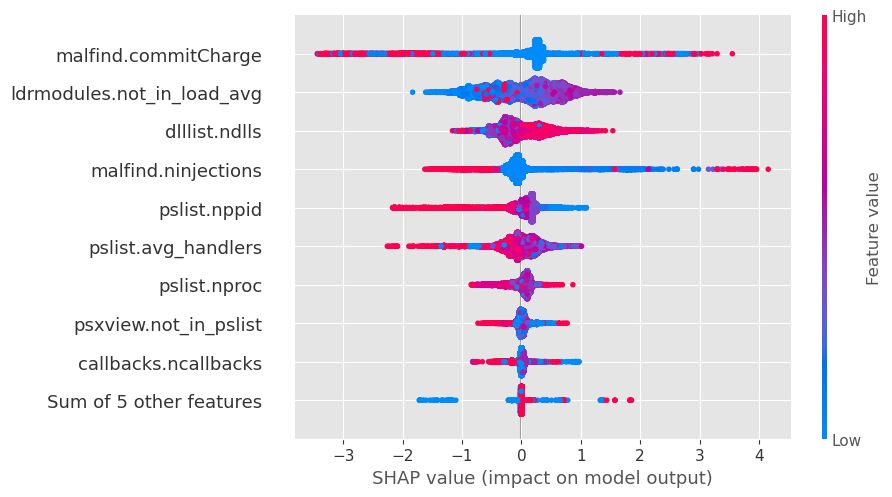

In [345]:

#shap.plots.bar(shap_values2[:,:,0])

shap.plots.beeswarm(shap_values2[:,:,2])

In [321]:
ShapRansomware=shap_values2[:, :, 0].values
ShapRansomware =np.array(ShapRansomware)
ShapRansomware = pd.DataFrame(ShapRansomware, columns= X2.columns)

#ShapRansomware["Category"]=MalwareDataSet.Category
#ShapRansomware["Family"]=MalwareDataSet.Family

In [323]:
#ShapRansomware.drop(["Category","Class","Family"], axis=1)
ShapRansomwareUmap = umap.UMAP(
  n_components=2, n_neighbors=10).fit_transform(ShapRansomware)

In [442]:
RansomwareDF= pd.DataFrame(ShapRansomwareUmap, columns=["x", "y"])
RansomwareDF["Category"]= MalwareDataSet.Category
RansomwareDF["Class"]= MalwareDataSet.Class
RansomwareDF["Family"]= MalwareDataSet.Family

In [443]:
RansomwareDF

x          y  Category  Class  Family
0     -2.618639  17.330572         0      1       1
1     -2.385819  18.051729         0      1       1
2     -2.615370  17.330631         0      1       1
3     -0.094625  18.268461         0      1       1
4      0.297698  18.161724         0      1       1
...         ...        ...       ...    ...     ...
29293 -3.436565   8.438326         0      1       5
29294 -2.955983   9.503894         0      1       5
29295 -3.392543   8.285359         0      1       5
29296 -3.370839   8.084224         0      1       5
29297 -3.416330   8.387156         0      1       5

[29298 rows x 5 columns]

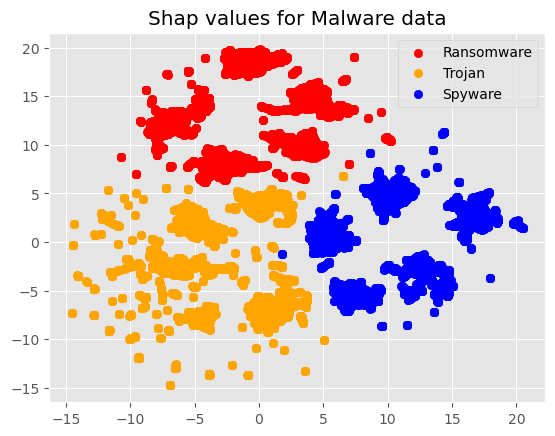

In [444]:
plt.scatter(RansomwareDF[RansomwareDF.Category==0]["x"], RansomwareDF[RansomwareDF.Category==0]["y"], color= "red", label= "Ransomware")
plt.scatter(RansomwareDF[RansomwareDF.Category==1]["x"], RansomwareDF[RansomwareDF.Category==1]["y"], color= "orange", label= "Trojan")
plt.scatter(RansomwareDF[RansomwareDF.Category==2]["x"], RansomwareDF[RansomwareDF.Category==2]["y"], color= "blue", label= "Spyware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Malware"]["x"], RansomwareDF[RansomwareDF.Class=="Malware"]["y"], color= "red", label= "Malware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Benign"]["x"], RansomwareDF[RansomwareDF.Class=="Benign"]["y"], color= "green", label= "Benign")
plt.title("Shap values for Malware data")
plt.legend()

Text(0.5, 1.0, 'Malware Families')

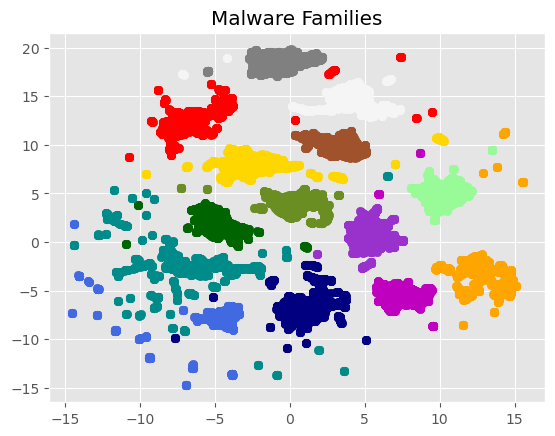

In [447]:
for i in range(len(MalwareDataSet.Family.unique())):
    plt.scatter(RansomwareDF[RansomwareDF.Family==i]["x"], RansomwareDF[RansomwareDF.Family==i]["y"], color= colors[i])
                
plt.title("Malware Families")

In [304]:
count2=0
for i in range(len(MalwareDataSet)):
    if MalwareDataSet["Category"][i] == MalwareDataSet["pred"][i]:
        count2 += 1
count2/len(MalwareDataSet)

0.7619632739436139

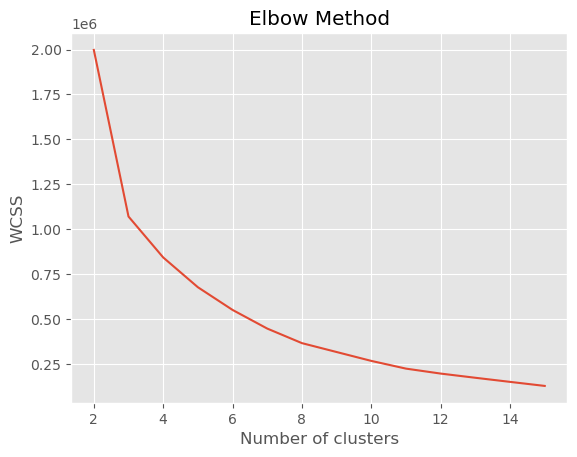

In [402]:
wcss = []

for i in range(2, 16):
    
    model =KMeans(n_clusters=i)
    model.fit(RansomwareDF[["x","y"]])
    wcss.append(model.inertia_)
plt.plot(range(2, 16), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [407]:
kmeansMalware= KMeans(n_clusters=3, random_state=1)
kmeansMalware8= KMeans(n_clusters=8, random_state=1)

In [408]:
MalwarePred= kmeansMalware.fit_predict(RansomwareDF[["x","y"]])
MalwarePred2= kmeansMalware8.fit_predict(RansomwareDF[["x","y"]])

In [441]:
RansomwareDF["Cluster"]= MalwarePred
RansomwareDF["Cluster1"]= MalwarePred2

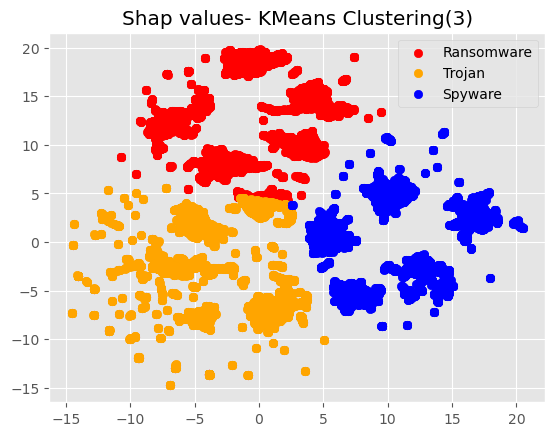

In [437]:
plt.scatter(RansomwareDF[RansomwareDF.Cluster==0]["x"], RansomwareDF[RansomwareDF.Cluster==0]["y"], color= "red", label= "Ransomware")
plt.scatter(RansomwareDF[RansomwareDF.Cluster==1]["x"], RansomwareDF[RansomwareDF.Cluster==1]["y"], color= "orange", label= "Trojan")
plt.scatter(RansomwareDF[RansomwareDF.Cluster==2]["x"], RansomwareDF[RansomwareDF.Cluster==2]["y"], color= "blue", label= "Spyware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Malware"]["x"], RansomwareDF[RansomwareDF.Class=="Malware"]["y"], color= "red", label= "Malware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Benign"]["x"], RansomwareDF[RansomwareDF.Class=="Benign"]["y"], color= "green", label= "Benign")
plt.title("Shap values- KMeans Clustering(3)")
plt.legend()

Text(0.5, 1.0, 'Shap values- KMeans Clustering(8)')

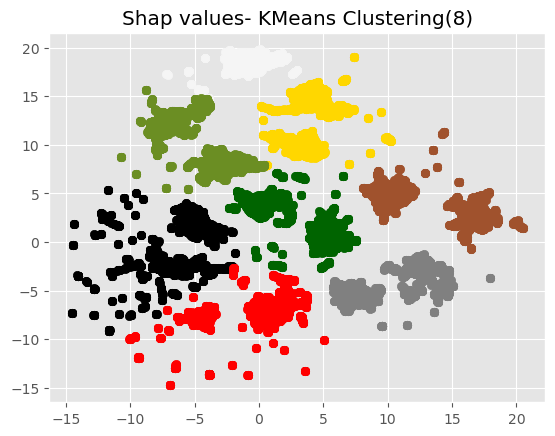

In [438]:
colors=["black","gray","whitesmoke","red","sienna","gold", "olivedrab", "darkgreen", "darkcyan","royalblue", "navy","darkorchid","m","orange","palegreen","darksalmon"]
for i in range(8):
    plt.scatter(RansomwareDF[RansomwareDF.Cluster1==i]["x"], RansomwareDF[RansomwareDF.Cluster1==i]["y"], color= colors[i])
plt.title("Shap values- KMeans Clustering(8)")
    

In [433]:
DBSCAN_cluster= DBSCAN(eps=1.5, min_samples=50).fit(RansomwareDF[["x","y"]])
DBSCANPRED=DBSCAN_cluster.labels_
RansomwareDF["Cluster2"]= DBSCANPRED

Text(0.5, 1.0, 'Shap values- DBSCAN')

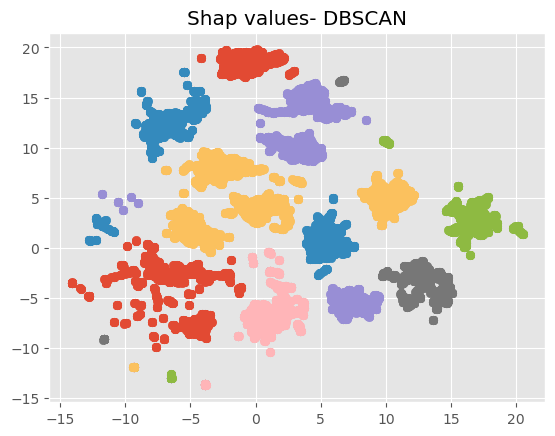

In [439]:
for i in range(len(RansomwareDF["Cluster2"].unique())):
    plt.scatter(RansomwareDF[RansomwareDF.Cluster2==i]["x"], RansomwareDF[RansomwareDF.Cluster2==i]["y"])
plt.title("Shap values- DBSCAN")
    

In [435]:
RansomwareDF["Cluster2"].unique()

array([ 0,  1,  2,  3, -1,  4,  5,  6,  9,  7,  8, 14, 10, 11, 12, 13, 15,
       16, 17, 19, 18], dtype=int64)

In [405]:
count2=0
for i in range(len(RansomwareDF)):
    if RansomwareDF["Category"][i] == RansomwareDF["Cluster"][i]:
        count2 += 1
print("Accuracy:",count2/len(MalwareDataSet),"%")

Accuracy: 0.9657997132910097 %


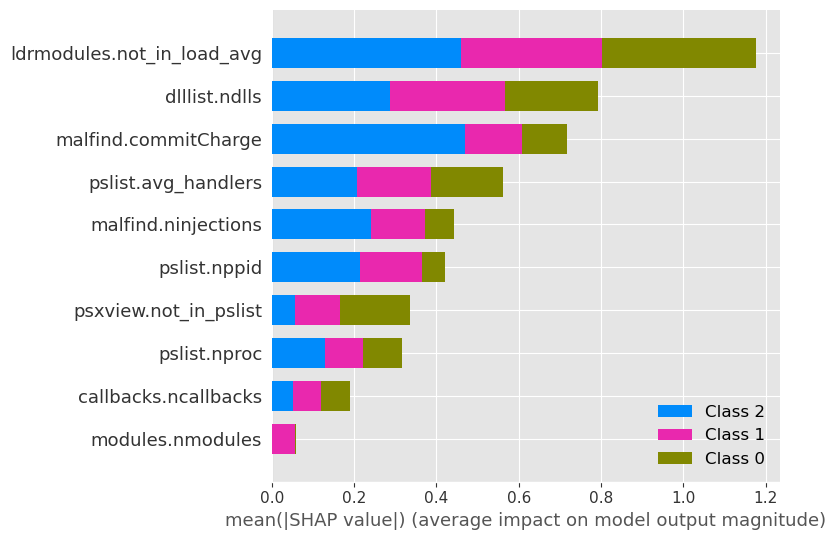

In [451]:
shap.summary_plot(
    [shap_values2[:, :, class_ind].values for class_ind in range(shap_values2.shape[-1])],
    feature_names=X2.columns,
    plot_type="bar", max_display=10
)

In [490]:
ClassifierTeste= xgb.XGBClassifier(n_estimators=500,
 min_child_weight=7,
 max_depth=20,
 learning_rate=0.2,
 gamma=0.4,
 early_stopping_rounds=50,
 colsample_bytree=0.7)
ClassifierTeste.fit(X1,Y1,eval_set=[(x1_test, y1_test)])

[0]	validation_0-mlogloss:1.13446
[1]	validation_0-mlogloss:0.96159
[2]	validation_0-mlogloss:0.83088
[3]	validation_0-mlogloss:0.72255
[4]	validation_0-mlogloss:0.63515
[5]	validation_0-mlogloss:0.57036
[6]	validation_0-mlogloss:0.51728
[7]	validation_0-mlogloss:0.47424
[8]	validation_0-mlogloss:0.43634
[9]	validation_0-mlogloss:0.40876
[10]	validation_0-mlogloss:0.38502
[11]	validation_0-mlogloss:0.36111
[12]	validation_0-mlogloss:0.34141
[13]	validation_0-mlogloss:0.32493
[14]	validation_0-mlogloss:0.31032
[15]	validation_0-mlogloss:0.29917
[16]	validation_0-mlogloss:0.28994
[17]	validation_0-mlogloss:0.28166
[18]	validation_0-mlogloss:0.27577
[19]	validation_0-mlogloss:0.26975
[20]	validation_0-mlogloss:0.26381
[21]	validation_0-mlogloss:0.25845
[22]	validation_0-mlogloss:0.25512
[23]	validation_0-mlogloss:0.25152
[24]	validation_0-mlogloss:0.24816
[25]	validation_0-mlogloss:0.24516
[26]	validation_0-mlogloss:0.24210
[27]	validation_0-mlogloss:0.24028
[28]	validation_0-mlogloss:0.2

[231]	validation_0-mlogloss:0.18618
[232]	validation_0-mlogloss:0.18615
[233]	validation_0-mlogloss:0.18615
[234]	validation_0-mlogloss:0.18615
[235]	validation_0-mlogloss:0.18610
[236]	validation_0-mlogloss:0.18571
[237]	validation_0-mlogloss:0.18563
[238]	validation_0-mlogloss:0.18560
[239]	validation_0-mlogloss:0.18549
[240]	validation_0-mlogloss:0.18538
[241]	validation_0-mlogloss:0.18519
[242]	validation_0-mlogloss:0.18481
[243]	validation_0-mlogloss:0.18476
[244]	validation_0-mlogloss:0.18419
[245]	validation_0-mlogloss:0.18417
[246]	validation_0-mlogloss:0.18410
[247]	validation_0-mlogloss:0.18403
[248]	validation_0-mlogloss:0.18391
[249]	validation_0-mlogloss:0.18365
[250]	validation_0-mlogloss:0.18353
[251]	validation_0-mlogloss:0.18349
[252]	validation_0-mlogloss:0.18340
[253]	validation_0-mlogloss:0.18340
[254]	validation_0-mlogloss:0.18337
[255]	validation_0-mlogloss:0.18337
[256]	validation_0-mlogloss:0.18335
[257]	validation_0-mlogloss:0.18335
[258]	validation_0-mlogloss:

[459]	validation_0-mlogloss:0.17409
[460]	validation_0-mlogloss:0.17409
[461]	validation_0-mlogloss:0.17408
[462]	validation_0-mlogloss:0.17404
[463]	validation_0-mlogloss:0.17390
[464]	validation_0-mlogloss:0.17387
[465]	validation_0-mlogloss:0.17387
[466]	validation_0-mlogloss:0.17379
[467]	validation_0-mlogloss:0.17379
[468]	validation_0-mlogloss:0.17379
[469]	validation_0-mlogloss:0.17378
[470]	validation_0-mlogloss:0.17378
[471]	validation_0-mlogloss:0.17378
[472]	validation_0-mlogloss:0.17378
[473]	validation_0-mlogloss:0.17378
[474]	validation_0-mlogloss:0.17378
[475]	validation_0-mlogloss:0.17378
[476]	validation_0-mlogloss:0.17377
[477]	validation_0-mlogloss:0.17377
[478]	validation_0-mlogloss:0.17377
[479]	validation_0-mlogloss:0.17376
[480]	validation_0-mlogloss:0.17370
[481]	validation_0-mlogloss:0.17370
[482]	validation_0-mlogloss:0.17358
[483]	validation_0-mlogloss:0.17358
[484]	validation_0-mlogloss:0.17350
[485]	validation_0-mlogloss:0.17348
[486]	validation_0-mlogloss:

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [492]:
start_time=timer(None)
explainer3 = shap.TreeExplainer(ClassifierTeste,seed=1)
shap_values3 = explainer3(X1)
timer(start_time)


 Time taken: 0 hours 2 minutes and 30 seconds.


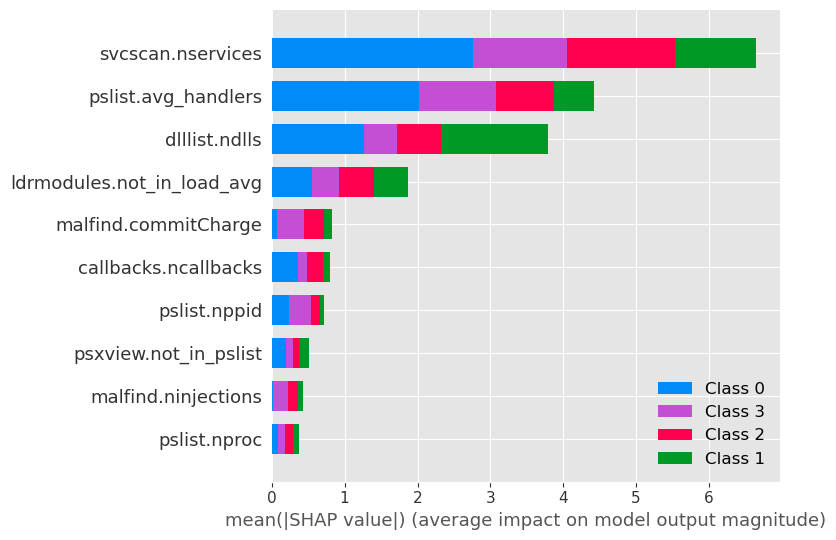

In [494]:
shap_values3.shape
shap.summary_plot(
    [shap_values3[:, :, class_ind].values for class_ind in range(shap_values3.shape[-1])],
    feature_names=X1.columns,
    plot_type="bar", max_display=10
)

In [479]:
Teste222=shap_values3[:, :, 2].values
Teste222 =np.array(Teste222)
Teste222 = pd.DataFrame(Teste222, columns= X2.columns)

In [480]:
TesteMap = umap.UMAP(
  n_components=2, n_neighbors=15).fit_transform(Teste222)
TesteDf= pd.DataFrame(TesteMap, columns=["x", "y"])
TesteDf["Category"]= MalwareDataSet.Category
TesteDf["Class"]= MalwareDataSet.Class
TesteDf["Family"]= MalwareDataSet.Family

In [499]:
Teste222=shap_values3[:, :, 0].values
Teste223=shap_values3[:, :, 1].values
Teste224=shap_values3[:, :, 2].values
Teste225=shap_values3[:, :, 3].values


Teste222 =np.array(Teste222)
Teste222 = pd.DataFrame(Teste222, columns= X1.columns)

Teste222["Category"]=dataset2.Category
Teste222["Family"]=dataset2.Family
Teste222=Teste222[Teste222.Category==0]

Teste223 =np.array(Teste223)
Teste223 = pd.DataFrame(Teste223, columns= X1.columns)
Teste223["Category"]=dataset2.Category
Teste223["Family"]=dataset2.Family
Teste223=Teste223[Teste223.Category==1]

Teste224 =np.array(Teste224)
Teste224 = pd.DataFrame(Teste224, columns= X1.columns)

Teste224["Category"]=dataset2.Category
Teste224["Family"]=dataset2.Family
Teste224=Teste224[Teste224.Category==2]

Teste225 =np.array(Teste225)
Teste225 = pd.DataFrame(Teste225, columns= X1.columns)
Teste225["Category"]=dataset2.Category
Teste225["Family"]=dataset2.Family
Teste225=Teste225[Teste225.Category==3]

dfs=[Teste222, Teste223, Teste224, Teste225]

DFTESTE= pd.concat(dfs)

In [498]:
DFTESTE

pslist.nproc  pslist.nppid  pslist.avg_handlers  dlllist.ndlls  \
0          0.350412      0.063625            -1.989797       0.831241   
1          0.194049     -0.440480             1.233939       1.618331   
2          0.001871      0.418995             1.889809       1.564918   
3          0.086237      0.377210             2.285473      -0.751015   
4          0.002018      0.123266             1.767058       1.803147   
...             ...           ...                  ...            ...   
45404     -0.048731      0.026491             0.644208       0.339953   
45405      0.110433     -0.013006             0.445219       0.615688   
45406      0.123054     -0.013206             0.446959       0.672601   
45407      0.130016     -0.018187             0.478541       0.373986   
45408      0.101871     -0.012833             0.757171      -0.272281   

       ldrmodules.not_in_load_avg  malfind.ninjections  malfind.commitCharge  \
0                        0.093881            -0.013096              0.032637   
1                        0.957638             0.017812             -0.046632   
2                       -0.439990            -0.000612              0.053390   
3                       -0.103341            -0.004337             -0.016074   
4                        0.932027             0.006790             -0.035882   
...                           ...                  ...                   ...   
45404                   -0.209724             0.477232              2.138753   
45405                    1.436659            -1.004434              1.222688   
45406                    0.275247            -0.969263              1.210885   
45407                    0.908279            -0.451199              0.700670   
45408                    1.209600            -0.290568              0.386943   

       psxview.not_in_pslist  psxview.not_in_eprocess_pool  modules.nmodules  \
0                   0.456458                      0.000000         -0.117894   
1                  -0.171855                      0.000000         -0.122942   
2                  -0.127162                      0.000000          0.225686   
3                  -0.108179                      0.000000         -0.331195   
4                   0.294487                      0.000000         -0.122942   
...                      ...                           ...               ...   
45404              -0.001627                      0.000073          0.055514   
45405              -0.054424                     -0.000249          0.053513   
45406              -0.054215                     -0.000265          0.053371   
45407              -0.121369                     -0.000169          0.026129   
45408              -0.098563                     -0.000142          0.005174   

       svcscan.nservices  callbacks.ncallbacks  callbacks.nanonymous  \
0              -2.279282              0.310251              0.000000   
1               2.912940              0.341443              0.000000   
2               3.197052              0.214729              0.000000   
3               3.790831              0.170886              0.000000   
4               3.178946              0.320974              0.000000   
...                  ...                   ...                   ...   
45404           0.185530              0.106741              0.001831   
45405           0.120185              0.081323              0.001538   
45406           0.123981              0.107634              0.001538   
45407           0.116716              0.262891              0.001551   
45408           0.301443             -0.174532              0.001480   

       callbacks.ngeneric  Category  Family  
0                     0.0         0       0  
1                     0.0         0       0  
2                     0.0         0       0  
3                     0.0         0       0  
4                     0.0         0       0  
...                   ...       ...     ...  
45404                

In [500]:
DFTESTEUMAP = umap.UMAP(
  n_components=2, n_neighbors=10).fit_transform(DFTESTE)
DFTESTEUMAP= pd.DataFrame(DFTESTEUMAP, columns=["x", "y"])
DFTESTEUMAP["Category"]= dataset2.Category
DFTESTEUMAP["Class"]= dataset2.Class

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!


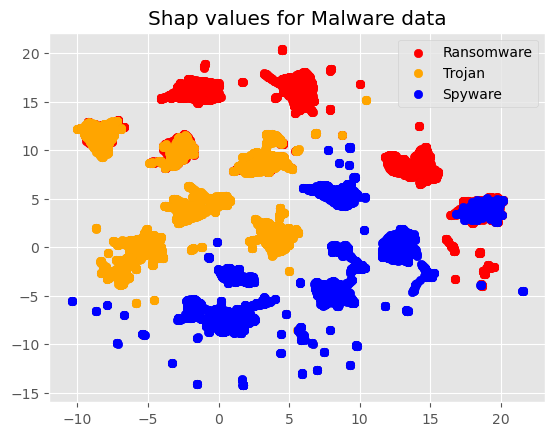

In [489]:
plt.scatter(DFTESTEUMAP[DFTESTEUMAP.Category==0]["x"], DFTESTEUMAP[DFTESTEUMAP.Category==0]["y"], color= "green", label= "Ransomware")
plt.scatter(DFTESTEUMAP[DFTESTEUMAP.Category==1]["x"], DFTESTEUMAP[DFTESTEUMAP.Category==1]["y"], color= "red", label= "Trojan")
plt.scatter(DFTESTEUMAP[DFTESTEUMAP.Category==2]["x"], DFTESTEUMAP[DFTESTEUMAP.Category==2]["y"], color= "orange", label= "Spyware")
plt.scatter(DFTESTEUMAP[DFTESTEUMAP.Category==3]["x"], DFTESTEUMAP[DFTESTEUMAP.Category==3]["y"], color= "blue", label= "Spyware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Malware"]["x"], RansomwareDF[RansomwareDF.Class=="Malware"]["y"], color= "red", label= "Malware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Benign"]["x"], RansomwareDF[RansomwareDF.Class=="Benign"]["y"], color= "green", label= "Benign")
plt.title("Shap values for Malware data")
plt.legend()

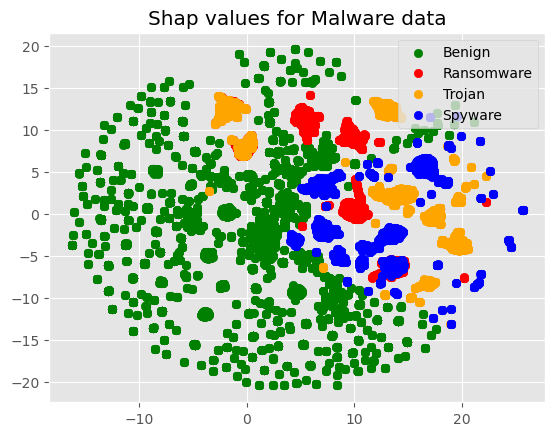

In [502]:
plt.scatter(DFTESTEUMAP[DFTESTEUMAP.Category==0]["x"], DFTESTEUMAP[DFTESTEUMAP.Category==0]["y"], color= "green", label= "Benign")
plt.scatter(DFTESTEUMAP[DFTESTEUMAP.Category==1]["x"], DFTESTEUMAP[DFTESTEUMAP.Category==1]["y"], color= "red", label= "Ransomware")
plt.scatter(DFTESTEUMAP[DFTESTEUMAP.Category==2]["x"], DFTESTEUMAP[DFTESTEUMAP.Category==2]["y"], color= "orange", label= "Trojan")
plt.scatter(DFTESTEUMAP[DFTESTEUMAP.Category==3]["x"], DFTESTEUMAP[DFTESTEUMAP.Category==3]["y"], color= "blue", label= "Spyware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Malware"]["x"], RansomwareDF[RansomwareDF.Class=="Malware"]["y"], color= "red", label= "Malware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Benign"]["x"], RansomwareDF[RansomwareDF.Class=="Benign"]["y"], color= "green", label= "Benign")
plt.title("Shap values for Malware data")
plt.legend()

In [333]:
ShapSPyware=shap_values2[:, :, 2].values
ShapSPyware =np.array(ShapSPyware)
ShapSPyware = pd.DataFrame(ShapSPyware, columns= X2.columns)

In [335]:
RansomwareDF["Category"]= MalwareDataSet.Category
RansomwareDF["Class"]= MalwareDataSet.Class


In [337]:
SpywareDF= pd.DataFrame(ShapSPyware, columns=["x", "y"])
SpywareDF["Category"]= MalwareDataSet.Category
SpywareDF["Class"]= MalwareDataSet.Class

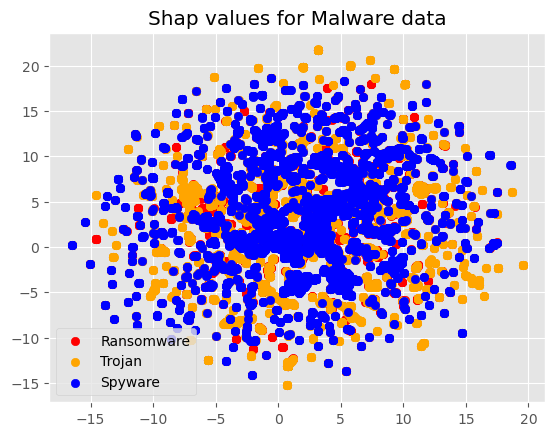

In [338]:
plt.scatter(SpywareDF[SpywareDF.Category==0]["x"], SpywareDF[SpywareDF.Category==0]["y"], color= "red", label= "Ransomware")
plt.scatter(SpywareDF[SpywareDF.Category==1]["x"], SpywareDF[SpywareDF.Category==1]["y"], color= "orange", label= "Trojan")
plt.scatter(SpywareDF[SpywareDF.Category==2]["x"], SpywareDF[SpywareDF.Category==2]["y"], color= "blue", label= "Spyware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Malware"]["x"], RansomwareDF[RansomwareDF.Class=="Malware"]["y"], color= "red", label= "Malware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Benign"]["x"], RansomwareDF[RansomwareDF.Class=="Benign"]["y"], color= "green", label= "Benign")
plt.title("Shap values for Malware data")
plt.legend()

In [339]:
ShapTrojan=shap_values2[:, :, 2].values
ShapTrojan =np.array(ShapTrojan)
ShapTrojan = pd.DataFrame(ShapTrojan, columns= X2.columns)
ShapTrojan = umap.UMAP(
  n_components=2, n_neighbors=10).fit_transform(ShapTrojan)

In [341]:
TrojanDF= pd.DataFrame(ShapTrojan, columns=["x", "y"])
TrojanDF["Category"]= MalwareDataSet.Category
TrojanDF["Class"]= MalwareDataSet.Class

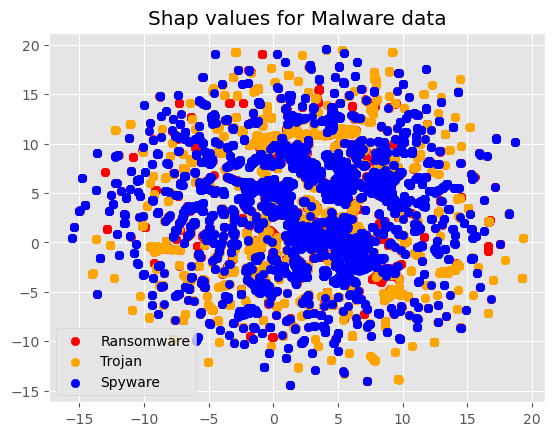

In [342]:
plt.scatter(TrojanDF[TrojanDF.Category==0]["x"], TrojanDF[TrojanDF.Category==0]["y"], color= "red", label= "Ransomware")
plt.scatter(TrojanDF[TrojanDF.Category==1]["x"], TrojanDF[TrojanDF.Category==1]["y"], color= "orange", label= "Trojan")
plt.scatter(TrojanDF[TrojanDF.Category==2]["x"], TrojanDF[TrojanDF.Category==2]["y"], color= "blue", label= "Spyware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Malware"]["x"], RansomwareDF[RansomwareDF.Class=="Malware"]["y"], color= "red", label= "Malware")
#plt.scatter(shapsDF[RansomwareDF.Class=="Benign"]["x"], RansomwareDF[RansomwareDF.Class=="Benign"]["y"], color= "green", label= "Benign")
plt.title("Shap values for Malware data")
plt.legend()